In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#!python write_filelist.py

Mounted at /content/gdrive


In [ ]:
!pip install easyfsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 791 kB/s 


In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset   
from torchvision.datasets import CIFAR100,Omniglot,FashionMNIST
from torchvision.models import resnet18,resnet34
torch.backends.cudnn.benchmark=True

from torch.utils.data import DataLoader
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [ ]:
num_clients = 5
num_rounds = 20
epochs = 5

batch_size = 32
SN_WAY = int(input("\nEnter number of classes for support and query sets: "))  # Number of classes in a task
SN_SHOT = int(input("\nEnter number of samples in each class for support set: "))  # Number of images per class in the support set
SN_QUERY = int(input("\nEnter number of samples in5 each class for query set:")) # Number of images per class in the query set


Enter number of classes for support and query sets: 5

Enter number of samples in each class for support set: 5

Enter number of samples in each class for query set:5


In [ ]:
print("\n Arranging train and test sets for Fashion MNIST... ")
image_size = 28


train_set = FashionMNIST(
    root="./data",
    train=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

test_set = FashionMNIST(
    root="./data",
    train=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(), 
        ]
    ),
    download=True,
)


 Arranging train and test sets for Fashion MNIST... 


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

def train_val_dataset(dataset, val_split=0.80):
    train1, val1 = train_test_split(list(range(len(dataset))), test_size=val_split)

    datasets = {}
    datasets['train1'] = Subset(dataset, train1)
    datasets['val1'] = Subset(dataset, val1)
    return datasets

print(len(train_set))
datasets = train_val_dataset(train_set)

val_set=datasets['train1']
train_set1=datasets['val1']

print(len(val_set))
print(len(train_set1))





60000
12000
48000


In [ ]:
def train_val_dataset2(dataset, val_split=0.75):
    v1, v2 = train_test_split(list(range(len(dataset))), test_size=val_split)

    datasets = {}
    datasets[0] = Subset(dataset, v1)
    datasets[1] = Subset(dataset, v2)
    return datasets

#*****************************
print("\nSecond division")
print(len(train_set1))
datasets = train_val_dataset2(train_set1)

val_set1=datasets[0]
train_set2=datasets[1]

print(len(val_set1))
print(len(train_set2))          #get temp2 for client 1



Second division
48000
12000
36000


In [ ]:
def train_val_dataset3(dataset, val_split=0.666666):
    v1, v2 = train_test_split(list(range(len(dataset))), test_size=val_split)

    datasets = {}
    datasets[0] = Subset(dataset, v1)
    datasets[1] = Subset(dataset, v2)
    return datasets

#*****************************
print("\nSecond division")
print(len(train_set2))
datasets = train_val_dataset3(train_set2)

val_set2=datasets[0]
train_set3=datasets[1]

print(len(val_set2))
print(len(train_set3))          #get temp2 for client 1



Second division
36000
12000
24000


In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=False)
convolutional_network.fc = nn.Flatten()
print("Prototypical Meta-Learning Model using Resnet18 Ready!")

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Prototypical Meta-Learning Model using Resnet18 Ready!


## Data Sampling into support set and query set

In [ ]:
def server_basedata():
    SN_WAY = 5  # Number of classes in a task
    SN_SHOT = 5  # Number of images per class in the support set
    SN_QUERY = 10 # Number of images per class in the query set
    N_TRAINING_EPISODES = 400
    N_VALIDATION_TASKS = 100

    train_set3.get_labels = lambda: [instance[1] for instance in train_set3]
    train_sampler = TaskSampler(
        train_set3, n_way=SN_WAY, n_shot=SN_SHOT, n_query=SN_QUERY, n_tasks=N_TRAINING_EPISODES
    )
    train_loader = DataLoader(
        train_set3,
        batch_sampler=train_sampler,
        num_workers=12, 
        pin_memory=True,
        collate_fn=train_sampler.episodic_collate_fn,
    )

    print("\nLarge training data of Fashion_MNIST Server side Global Model is ready!")

    return train_loader

In [ ]:
def client1_data():      
  C1N_WAY = 5
  C1N_SHOT = 5
  C1N_QUERY = 10
  C1N_EVALUATION_TASKS = 100

  print("\nNumber of evaluation tasks taken 100.")

  # The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
  val_set.get_labels = lambda: [
      instance[1] for instance in val_set
  ]
  val_sampler1 = TaskSampler(
      val_set, n_way=C1N_WAY, n_shot=C1N_SHOT, n_query=C1N_QUERY, n_tasks=C1N_EVALUATION_TASKS
  )
  
  test_loader1 = DataLoader(
      val_set,
      batch_sampler=val_sampler1,
      num_workers=12,
      pin_memory=True,
      collate_fn=val_sampler1.episodic_collate_fn,
  )

  print("Test Dataset with given support and query sets for client 1 ready!")


  with tqdm(enumerate(test_loader1), total=len(test_loader1)) as tqdm_train:
          for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
      ) in tqdm_train:
              if episode_index==5:
                      s1i,q1i=support_images,query_images
                      print("\nEpsiode index=",episode_index)
                      s1_images,s1_labels,q1_images, q1_labels = support_images.cuda(),support_labels.cuda(),query_images.cuda(), query_labels.cuda()


  print("\n New Test Sample for Client-1 private data ready!")
  plot_images(s1i, "support images", images_per_row=C1N_WAY)
  plot_images(q1i, "query images", images_per_row=C1N_SHOT)
  return s1_images,s1_labels,q1_images, q1_labels,class_ids



In [ ]:
def client2_data():      
  C1N_WAY = 5
  C1N_SHOT = 5
  C1N_QUERY = 10
  C1N_EVALUATION_TASKS = 100

  print("\nNumber of evaluation tasks taken 100.")

  # The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
  val_set1.get_labels = lambda: [
      instance[1] for instance in val_set1
  ]
  val_sampler2 = TaskSampler(
      val_set1, n_way=C1N_WAY, n_shot=C1N_SHOT, n_query=C1N_QUERY, n_tasks=C1N_EVALUATION_TASKS
  )
  
  test_loader2 = DataLoader(
      val_set1,
      batch_sampler=val_sampler2,
      num_workers=12,
      pin_memory=True,
      collate_fn=val_sampler2.episodic_collate_fn,
  )

  print("Test Dataset with given support and query sets for client 1 ready!")


  with tqdm(enumerate(test_loader2), total=len(test_loader2)) as tqdm_train:
          for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
      ) in tqdm_train:
              if episode_index==5:
                      s1i,q1i=support_images,query_images
                      print("\nEpsiode index=",episode_index)
                      s1_images,s1_labels,q1_images, q1_labels = support_images.cuda(),support_labels.cuda(),query_images.cuda(), query_labels.cuda()


  print("\n New Test Sample for Client-2 private data ready!")
  plot_images(s1i, "support images", images_per_row=C1N_WAY)
  plot_images(q1i, "query images", images_per_row=C1N_SHOT)
  return s1_images,s1_labels,q1_images, q1_labels,class_ids



In [ ]:
def client3_data():      
  C1N_WAY = 5
  C1N_SHOT = 5
  C1N_QUERY = 10
  C1N_EVALUATION_TASKS = 100

  print("\nNumber of evaluation tasks taken 100.")

  # The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
  val_set2.get_labels = lambda: [
      instance[1] for instance in val_set2
  ]
  val_sampler3 = TaskSampler(
      val_set2, n_way=C1N_WAY, n_shot=C1N_SHOT, n_query=C1N_QUERY, n_tasks=C1N_EVALUATION_TASKS
  )
  
  test_loader3 = DataLoader(
      val_set2,
      batch_sampler=val_sampler3,
      num_workers=12,
      pin_memory=True,
      collate_fn=val_sampler3.episodic_collate_fn,
  )

  print("Test Dataset with given support and query sets for client 1 ready!")


  with tqdm(enumerate(test_loader3), total=len(test_loader3)) as tqdm_train:
          for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
      ) in tqdm_train:
              if episode_index==5:
                      s1i,q1i=support_images,query_images
                      print("\nEpsiode index=",episode_index)
                      s1_images,s1_labels,q1_images, q1_labels = support_images.cuda(),support_labels.cuda(),query_images.cuda(), query_labels.cuda()


  print("\n New Test Sample for Client-3 private data ready!")
  plot_images(s1i, "support images", images_per_row=C1N_WAY)
  plot_images(q1i, "query images", images_per_row=C1N_SHOT)
  return s1_images,s1_labels,q1_images, q1_labels,class_ids



In [ ]:
def server_testdata():
    SN_WAY = 5
    SN_SHOT = 5
    SN_QUERY = 10
    #SN_WAY = int(input("\n: Enter number of classes for support and query sets: "))  # Number of classes in a task
    #SN_SHOT = int(input("\n:Enter number of samples in each class for support set: "))  # Number of images per class in the support set
    #SN_QUERY = int(input("\nEnter number of samples in each class for query set:")) # Number of images per class in the query set
    SN_EVALUATION_TASKS = 100

    print("\nNumber of evaluation tasks taken 100.")

    # The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
    test_set.get_labels = lambda: [
        instance[1] for instance in test_set
    ]
    test_sampler = TaskSampler(
        test_set, n_way=SN_WAY, n_shot=SN_SHOT, n_query=SN_QUERY, n_tasks=SN_EVALUATION_TASKS
    )
    
    test_loader = DataLoader(
        test_set,
        batch_sampler=test_sampler,
        num_workers=12,
        pin_memory=True,
        collate_fn=test_sampler.episodic_collate_fn,
    )

    print("\nTest Dataset with given support and query sets for server ready!")



    with tqdm(enumerate(test_loader), total=len(test_loader)) as tqdm_train: #server new data 
            for episode_index, (
              support_images,
              support_labels,
              query_images,
              query_labels,
              class_ids,
        ) in tqdm_train:
                if episode_index==6:
                        si,qi=support_images,query_images
                        print("\nEpsiode index=",episode_index)
                        s_images,s_labels,q_images, q_labels = support_images.cuda(),support_labels.cuda(),query_images.cuda(), query_labels.cuda()

    print("\n New test sample for Server side testing ready! ")
    plot_images(si, "support images", images_per_row=SN_SHOT)
    plot_images(qi, "query images", images_per_row=SN_QUERY)
    return s_images,s_labels,q_images, q_labels,class_ids

## Training data for server-global model

In [ ]:
train_accu=[]
train_losses=[]
def Server_BaseTrain(global_model, train_loader):
    """
    This function updates/trains client model on client data
    """
    global_model.train()
    optimizer=optim.SGD(global_model.parameters(),lr=0.1)
    loss_fn=nn.CrossEntropyLoss()
    running_loss=0
    correct=0
    total=0
    with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
         for episode_index, (
          support_images,
          support_labels,
          query_images,
          query_labels,
           class_ids,
    ) in tqdm_train:
            print("\nEpsiode index=",episode_index)
            support_images,support_labels,query_images, query_labels = support_images.cuda(),support_labels.cuda(),query_images.cuda(), query_labels.cuda()
            optimizer.zero_grad()
            outputs = global_model(support_images, support_labels, query_images)
            loss=loss_fn(outputs,query_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
    
            _, predicted = outputs.max(1)
            total += query_labels.size(0)
            correct += predicted.eq(query_labels).sum().item()
      
            print(loss.item())
           

            print("\nGround Truth / Predicted")
            for i in range(len(query_labels)):
                  print(f"{train_set.classes[class_ids[query_labels[i]]]} / {train_set.classes[class_ids[predicted[i]]]}")
            
    

    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total

    print('\nTrain Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

    train_accu.append(accu)
    train_losses.append(train_loss)
    return accu
    
   


    

# Federated learning Client and Server updating methods

In [ ]:
train_accu=[]
train_losses=[]
def client_update(client_model, optimizer, support_images,support_labels,query_images, query_labels,class_ids):
    """
    This function updates/trains client model on client data
    """
    client_model.train()
    loss_fn=nn.CrossEntropyLoss()
    running_loss=0
    correct=0
    total=0

    support_images,support_labels,query_images, query_labels = support_images.cuda(),support_labels.cuda(),query_images.cuda(), query_labels.cuda()
    optimizer.zero_grad()
    outputs = client_model(support_images, support_labels, query_images)
    loss=loss_fn(outputs,query_labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = outputs.max(1)
    total += query_labels.size(0)
    correct += predicted.eq(query_labels).sum().item()
      
    train_loss=running_loss
    accu=100.*correct/total
    
    train_accu.append(accu)
    train_losses.append(train_loss)

    print("\nGround Truth / Predicted")
    for i in range(len(query_labels)):
        print(f"{train_set.classes[class_ids[query_labels[i]]]} / {train_set.classes[class_ids[predicted[i]]]}")
    return  client_model.state_dict(),train_loss, accu


    

In [ ]:
def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    
    tensor_1=list(model_1.parameters())
    tensor_2=list(model_2.parameters())
    
    norm=sum([torch.sum((tensor_1[i]-tensor_2[i])**2) 
        for i in range(len(tensor_1))])
    
    return norm

In [ ]:
mu=1.5

In [ ]:
from copy import deepcopy
def prox_update(global_model,client_model, optimizer, support_images,support_labels,query_images, query_labels,class_ids):
  mu=1.5
  client_model.train()
  loss_fn=nn.CrossEntropyLoss()
  running_loss=0
  correct=0
  total=0
   
  
  support_images,support_labels,query_images, query_labels = support_images.cuda(),support_labels.cuda(),query_images.cuda(), query_labels.cuda()
  optimizer.zero_grad()
  outputs = client_model(support_images, support_labels, query_images)
  loss=loss_fn(outputs,query_labels)
  loss+=mu/2*difference_models_norm_2(client_model,global_model)
  loss.backward()
  optimizer.step()

  running_loss += loss.item()
  _, predicted = outputs.max(1)
  total += query_labels.size(0)
  correct += predicted.eq(query_labels).sum().item()
    
  train_loss=running_loss
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)

  print("\nGround Truth / Predicted")
  for i in range(len(query_labels)):
      print(f"{train_set.classes[class_ids[query_labels[i]]]} / {train_set.classes[class_ids[predicted[i]]]}")
  return  client_model.state_dict(),train_loss, accu


  


In [ ]:
def server_aggregate(global_model, client_models):
      global_dict = global_model.state_dict()
      for k in global_dict.keys():
          global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
      global_model.load_state_dict(global_dict)
      for model in client_models:
          model.load_state_dict(global_model.state_dict())
      return global_model

In [ ]:
eval_losses=[]
eval_accu=[]

def test(global_model,support_images,support_labels,query_images, query_labels,class_ids):
  global_model.eval()
  loss_fn=nn.CrossEntropyLoss()
  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    train_accu=[]
    train_losses=[]
    support_images,support_labels,query_images, query_labels = support_images.cuda(),support_labels.cuda(),query_images.cuda(), query_labels.cuda()
    outputs = global_model(support_images, support_labels, query_images)
    loss=loss_fn(outputs,query_labels)
    running_loss+=loss.item()
    _, predicted = outputs.max(1)
    total += query_labels.size(0)
    correct += predicted.eq(query_labels).sum().item()
  
  test_loss=running_loss
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print("\nGround Truth / Predicted")
  for i in range(len(query_labels)):
      print(f"{test_set.classes[class_ids[query_labels[i]]]} / {test_set.classes[class_ids[predicted[i]]]}")

  return test_loss,accu 
  

## Client updates

# Performing Federated Few-shot learning

## Server Side to Client Side

In [ ]:
import copy
import time

In [ ]:
global_model = PrototypicalNetworks(convolutional_network).cuda()

#get Server whole base train data

train_loader= server_basedata()
print("Training FMINST base data on Server side...")
accu=Server_BaseTrain(global_model,train_loader)

#Server_BaseTrain2(global_model,Otrain_loader)

w_glob = global_model.state_dict()





Large training data of Fashion_MNIST Server side Global Model is ready!
Training FMINST base data on Server side...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/400 [00:00<?, ?it/s]


Epsiode index= 0


  0%|          | 1/400 [00:08<54:58,  8.27s/it]

1.4007660150527954

Ground Truth / Predicted
Shirt / Dress
Shirt / Pullover
Shirt / Shirt
Shirt / Bag
Shirt / Bag
Shirt / Dress
Shirt / Dress
Shirt / Bag
Shirt / Pullover
Shirt / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Bag
Trouser / Shirt
Trouser / Trouser
Trouser / Dress
Trouser / Shirt
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Dress
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Bag
Pullover / Bag
Pullover / Bag
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Dress / Shirt
Dress / Shirt
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Shirt
Dress / Shirt
Dress / Shirt
Dress / Bag
Dress / Shirt

Epsiode index= 1
1.531591773033142

Ground Truth / Predicted
Shirt / Shirt
Shirt / Ankle boot
Shirt / Shirt
Shirt / Shirt
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Sandal / Bag
San

  1%|          | 4/400 [00:08<09:45,  1.48s/it]

Bag / T-shirt/top
Trouser / Bag
Trouser / Trouser
Trouser / Coat
Trouser / Coat
Trouser / Pullover
Trouser / Coat
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Bag
Coat / T-shirt/top
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / Trouser
T-shirt/top / Coat

Epsiode index= 3
1.4220352172851562

Ground Truth / Predicted
Ankle boot / Coat
Ankle boot / Sandal
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Shirt
Ankle boot / Coat
Ankle boot / Ankle boot
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Shirt / Sandal
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Dress / Dress
Dress / Sandal
Dress / S

  2%|▏         | 8/400 [00:08<03:12,  2.03it/s]

2.110720634460449

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Pullover
Ankle boot / Dress
Ankle boot / Pullover
Ankle boot / Sandal
Ankle boot / Ankle boot
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Pullover / Ankle boot
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Sandal / Sandal
Sandal / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Sandal / Sandal
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Sandal
Dress / Pullover
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Ankle boot
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Ankle boot

Epsiode index= 6
1.9325494766235352

Ground Truth / Predicted
Bag / Bag
Bag / Sneaker


  2%|▎         | 10/400 [00:09<02:12,  2.93it/s]


Epsiode index= 8
1.9467891454696655

Ground Truth / Predicted
Shirt / Shirt
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Bag
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Bag
Shirt / T-shirt/top
Shirt / Sandal
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Sandal
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Bag / T-shirt/top
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Sandal
Dress / Shirt
Dress / Dress
Dress / Sandal

Epsiode index= 9
3.282228708267212

Ground Truth / Predicted
Sandal / Ankle boot
Sandal / T-shirt/top
Sandal / Ankle boot
Sandal / Ankle bo

  3%|▎         | 12/400 [00:09<01:39,  3.91it/s]

3.46652889251709

Ground Truth / Predicted
Bag / Sneaker
Bag / Sandal
Bag / Sneaker
Bag / Pullover
Bag / Pullover
Bag / Sneaker
Bag / Sneaker
Bag / Sneaker
Bag / Sneaker
Bag / Sneaker
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / Bag
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Dress / Dress
Dress / Sneaker
Dress / Dress
Dress / Dress
Dress / Sandal
Dress / Pullover
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Sneaker / Bag
Sneaker / Bag
Sneaker / Sandal
Sneaker / Dress
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Bag
Sneaker / Dress
Sneaker / Sneaker
Pullover / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Pullover
Pullover / Bag
Pullover / Sandal
Pullover / Pullover

Epsiode index= 11
3.0489249229431152

Ground Truth / Predicted
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Bag
Shirt / Bag
Shirt / Shirt
Shirt / Bag
Shirt / Bag
Sh

  4%|▎         | 14/400 [00:09<01:14,  5.17it/s]


Epsiode index= 13
2.978243827819824

Ground Truth / Predicted
Shirt / T-shirt/top
Shirt / Trouser
Shirt / T-shirt/top
Shirt / Coat
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / Trouser
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Shirt
Coat / Shirt
Coat / Trouser
Coat / T-shirt/top
Coat / Shirt
Coat / Trouser
Coat / Trouser
Coat / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Shirt
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Shirt
Trouser / Trouser
Trouser / Shirt
Tr

  4%|▍         | 18/400 [00:09<00:52,  7.26it/s]

2.280226707458496

Ground Truth / Predicted
Pullover / Bag
Pullover / Ankle boot
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Bag
Pullover / Bag
Pullover / Bag
Pullover / Bag
Pullover / Pullover
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Pullover
Coat / Pullover
Coat / Bag
Coat / Coat
Coat / Bag
Coat / Bag
Coat / Coat
Coat / Pullover
T-shirt/top / Pullover
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Ankle boot
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Ankle boot
Bag / Ankle boot
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag

Epsiode index= 16
3.4107298851013184

Grou

  5%|▌         | 20/400 [00:09<00:46,  8.11it/s]

2.539199113845825

Ground Truth / Predicted
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Pullover
Pullover / Dress
Pullover / Bag
Pullover / Dress
Pullover / Bag
Pullover / Pullover
Pullover / Trouser
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Trouser
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Sandal
Bag / Pullover
Bag / Bag
Bag / Pullover
Bag / Bag
Trouser / Pullover
Trouser / Dress
Trouser / Dress
Trouser / Trouser
Trouser / Dress
Trouser / Dress
Trouser / Sandal
Trouser / Trouser
Trouser / Sandal
Trouser / Dress
Dress / Pullover
Dress / Dress
Dress / Trouser
Dress / Trouser
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Pullover

Epsiode index= 19
2.1632602214813232

Ground Truth / Predicted
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Trouser
Ankle boot / Coat
Ankle b

  6%|▌         | 24/400 [00:10<00:39,  9.58it/s]

2.7541234493255615

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Sandal
Ankle boot / Ankle boot
Bag / Ankle boot
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Ankle boot
Bag / Sandal
Bag / Bag
Bag / Coat
Bag / Ankle boot
Bag / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Coat / Pullover
Coat / Pullover
Coat / Bag
Coat / Pullover
Coat / Ankle boot
Coat / Coat
Coat / Pullover
Coat / Bag
Coat / Coat
Coat / Bag
Pullover / Coat
Pullover / Coat
Pullover / Ankle boot
Pullover / Coat
Pullover / Bag
Pullover / Ankle boot
Pullover / Coat
Pullover / Coat
Pullover / Bag
Pullover / Ankle boot

Epsiode index= 22
2.739727258682251

Ground Truth / Predicted
T-shirt/top / Bag
T-shirt/top / Pullover
T-shirt/top / Bag
T-shir

  6%|▋         | 26/400 [00:10<00:34, 10.73it/s]


Epsiode index= 24
2.301628828048706

Ground Truth / Predicted
T-shirt/top / Dress
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / T-shirt/top
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Coat
Dress / Dress
Dress / Shirt
Dress / T-shirt/top
Dress / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Dress
Coat / Coat
Coat / Dress

Epsiode index= 25
1.8718639612197876

Ground Truth / Predicted
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat / Coat

  7%|▋         | 28/400 [00:10<00:36, 10.27it/s]

Coat / Trouser
Coat / Coat
Coat / Shirt
Coat / Shirt
Coat / Dress
Trouser / Dress
Trouser / Coat
Trouser / Dress
Trouser / Coat
Trouser / Dress
Trouser / Ankle boot
Trouser / Trouser
Trouser / Dress
Trouser / Coat
Trouser / Ankle boot
Ankle boot / Trouser
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Trouser
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Trouser
Ankle boot / Ankle boot
Ankle boot / Coat

Epsiode index= 27
2.7676918506622314

Ground Truth / Predicted
Coat / Sandal
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Pullover
Coat / Sandal
Coat / Coat
Coat / Bag
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Bag / Coat
Bag / Bag
Bag / Coat
Bag / Sneaker
Bag / Pullover
Bag / Coat
Bag / Sneaker
Bag / Sneaker
Bag / Coat
Bag / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / B

  8%|▊         | 32/400 [00:10<00:32, 11.19it/s]

2.1135828495025635

Ground Truth / Predicted
Dress / Coat
Dress / Trouser
Dress / Coat
Dress / Coat
Dress / Dress
Dress / Coat
Dress / Trouser
Dress / Trouser
Dress / Pullover
Dress / Trouser
Coat / Pullover
Coat / Coat
Coat / Trouser
Coat / Pullover
Coat / Sneaker
Coat / Pullover
Coat / Dress
Coat / Dress
Coat / Coat
Coat / Dress
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Coat
Pullover / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Trouser
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Trouser
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker

Epsiode index= 30
4.182687282562256

Ground Truth / Predicted
Dress / Bag
Dress / T-shirt/top
Dress / Dress
Dress / Bag
Dress / T-shir

  8%|▊         | 34/400 [00:11<00:31, 11.64it/s]

2.120140552520752

Ground Truth / Predicted
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / Sandal
T-shirt/top / Bag
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sandal
Bag / T-shirt/top
Bag / T-shirt/top
Bag / Bag
Bag / Sneaker
Bag / Pullover
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / Bag
Bag / Pullover
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / T-shirt/top
Sandal / T-shirt/top
Sandal / Sandal
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sandal
Pullover / Pullover
Pullover / Bag
Pullover / T-shirt/top
Pullover / Bag
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Bag
Pullover / Bag
Pullover / T-shirt/top

Epsiode index= 33
1.9413865804672241

Ground Truth /

  9%|▉         | 36/400 [00:11<00:31, 11.58it/s]


Epsiode index= 35
2.4045844078063965

Ground Truth / Predicted
Trouser / Trouser
Trouser / Sandal
Trouser / Trouser
Trouser / Sandal
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Coat
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sneaker
Dress / Sandal
Dress / Sandal
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Sandal
Dress / Sandal
Dress / Dress
Dress / Trouser
Dress / Sandal
Coat / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Dress
Coat / Trouser
Coat / Coat
Coat / Trouser
Coat / Trouser
Coat / Dress
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Dress
Sneaker / Sneaker
Sneaker / Sneaker

Epsiode index= 36
2.313389778137207

Ground Truth / Predicted
Shirt / Trouser
Shirt / Dress
Shirt / Dress
Shirt / Shirt
Shirt / Shirt
Shirt / Trou

 10%|█         | 40/400 [00:11<00:31, 11.27it/s]

Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Dress
Sneaker / Dress
Sneaker / Sandal
Sneaker / Dress
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sandal

Epsiode index= 38
1.3951114416122437

Ground Truth / Predicted
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Sandal
Shirt / Pullover
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Bag
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sneaker
Sandal / Bag
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Bag / Pullover
Bag / Sandal
Bag / Sneaker
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Pullover / Bag
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt

 10%|█         | 42/400 [00:11<00:31, 11.30it/s]

2.152317523956299

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Sandal
Trouser / Sandal
Trouser / Trouser
Coat / Trouser
Coat / Coat
Coat / Coat
Coat / Trouser
Coat / Coat
Coat / Sandal
Coat / Coat
Coat / Sandal
Coat / Coat
Coat / Coat
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Sandal
Bag / Trouser
Bag / Coat
Bag / Sandal
Bag / Bag
Bag / Bag
Bag / Bag
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sneaker
Sandal / Bag
Sandal / Bag
Sandal / Sneaker
Sandal / Sneaker
Sandal / Bag
Sandal / Trouser
Sandal / Sneaker

Epsiode index= 41
2.211771249771118

Ground Truth / Predicted
Trouser / Trouser
Trouser / Sandal
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Ankle boot
Trouser / Trouser
Trouser / Tr

 12%|█▏        | 46/400 [00:12<00:29, 11.99it/s]

1.391972303390503

Ground Truth / Predicted
Trouser / Ankle boot
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Ankle boot
Trouser / Trouser
Trouser / Trouser
Sandal / Ankle boot
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Ankle boot / Sandal
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Trouser
Ankle boot / Pullover
Ankle boot / Sandal
Ankle boot / Sandal
Ankle boot / Sandal
Ankle boot / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Trouser
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Shirt / Shirt
Shirt / Pullover
Shirt / Trouser
Shirt / Pullover
Shirt / Shirt
Shirt / Pullover
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Sandal

Epsiode index= 44
2.21010422706604

Grou

 12%|█▏        | 48/400 [00:12<00:29, 11.91it/s]

2.209693670272827

Ground Truth / Predicted
Shirt / Dress
Shirt / Dress
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Shirt / T-shirt/top
Shirt / Trouser
Shirt / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Dress
Bag / T-shirt/top
Bag / Dress
Bag / Dress
Bag / Bag
Bag / Dress
Bag / T-shirt/top
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / T-shirt/top
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Dress
T-shirt/top / Shirt
T-shirt/top / Trouser
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Dress / Trouser
Dress / T-shirt/top
Dress / Dress
Dress / Shirt
Dress / Trouser
Dress / Dress
Dress / Shirt
Dress / Trouser
Dress / Dress
Dress / Trouser

Epsiode index= 47
2.6483335494995117

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / Tr

 12%|█▎        | 50/400 [00:12<00:30, 11.32it/s]

T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / Coat
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
Coat / T-shirt/top
Coat / Coat
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Coat
Coat / Shirt
Coat / Shirt
Coat / Shirt
Coat / Shirt
Coat / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal

Epsiode index= 49
2.7847495079040527

Ground Truth / Predicted
Bag / Sandal
Bag / T-shirt/top
Bag / Sandal
Bag / Sandal
Bag / Coat
Bag / T-shirt/top
Bag / Sandal
Bag / Sandal
Bag / Sandal
Bag / Sandal
Coat / Coat
Coat / Trouser
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Trouser
Coat / Sandal
Coat / Coat
Coat / T-shirt/top
Coat / Sandal
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / Sandal
T-shirt/top / T-sh

 13%|█▎        | 52/400 [00:12<00:30, 11.38it/s]

Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Dress

Epsiode index= 51
2.654587507247925

Ground Truth / Predicted
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Sandal
T-shirt/top / Ankle boot
T-shirt/top / Ankle boot
Dress / T-shirt/top
Dress / Dress
Dress / Ankle boot
Dress / Ankle boot
Dress / Sandal
Dress / Ankle boot
Dress / Dress
Dress / Ankle boot
Dress / Shirt
Dress / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Ankle boot / Sandal
Ankle boot / Dress
Ankle boot / Shirt
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Dress
Ankle boot / Ankle boot
Shirt / Shirt
Shirt / Sandal
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Dress
Shirt / Dress
Shirt / Shirt
Shirt 

 14%|█▎        | 54/400 [00:12<00:32, 10.74it/s]

3.094104528427124

Ground Truth / Predicted
T-shirt/top / Sandal
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / Trouser
T-shirt/top / Dress
T-shirt/top / Ankle boot
T-shirt/top / Dress
Ankle boot / Trouser
Ankle boot / Ankle boot
Ankle boot / T-shirt/top
Ankle boot / Sandal
Ankle boot / Trouser
Ankle boot / T-shirt/top
Ankle boot / Dress
Ankle boot / Sandal
Ankle boot / Dress
Ankle boot / Sandal
Dress / Trouser
Dress / Ankle boot
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Trouser
Dress / Dress
Dress / Ankle boot
Trouser / Trouser
Trouser / Dress
Trouser / Dress
Trouser / Dress
Trouser / Dress
Trouser / Trouser
Trouser / Dress
Trouser / Dress
Trouser / Ankle boot
Trouser / Dress
Sandal / Sandal
Sandal / Ankle boot
Sandal / T-shirt/top
Sandal / Sandal
Sandal / T-shirt/top
Sandal / Sandal
Sandal / Trouser
Sandal / T-shirt/top
Sandal / T-shirt/top
Sandal / T-shirt/top

Epsiod

 14%|█▍        | 58/400 [00:13<00:30, 11.03it/s]

T-shirt/top / Sandal
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / Coat
T-shirt/top / T-shirt/top

Epsiode index= 56
1.0708627700805664

Ground Truth / Predicted
Trouser / Trouser
Trouser / Bag
Trouser / T-shirt/top
Trouser / Trouser
Trouser / T-shirt/top
Trouser / T-shirt/top
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Trouser
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Pullover / Bag
Pullover /

 15%|█▌        | 60/400 [00:13<00:31, 10.96it/s]

1.8244472742080688

Ground Truth / Predicted
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Dress
Trouser / Dress
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Pullover / Pullover
Pullover / Trouser
Pullover / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Pullover
Dress / Pullover
Dress / Pullover
Dress / Pullover
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Pullover
Dress / Trouser
Dress / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Trouser
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Trouser
Ankle boot / Dress
Ankle boot / Ankle boot
Ankle boot / Trouser
Ankle boot / Bag
Bag / Bag
Bag / Trouser
Bag / Ankle boot
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Trouser
Bag / Trouser

Epsiode index= 59
1.4212465286254883

Ground Truth / Predicted
Sandal / Bag
Sandal / Ba

 16%|█▌        | 62/400 [00:13<00:29, 11.53it/s]

Dress / Trouser
Dress / Sandal
Dress / Sandal
Dress / Trouser
Dress / Dress
Dress / Pullover
Dress / Dress
Dress / Pullover
Dress / Trouser
Dress / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Dress
Sandal / Dress
Sandal / Dress
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker

Epsiode index= 61
1.9081822633743286

Ground Truth / Predicted
Ankle boot / Sandal
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Sandal
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Ankle boot
Coat / Coat
Coat / Sandal
Coat / Pullover
Coat / Pullover
Coat / Ankle boot
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Ankle boot
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Sandal
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Sandal / Trouser
Sandal / 

 16%|█▋        | 66/400 [00:13<00:29, 11.17it/s]

1.7052932977676392

Ground Truth / Predicted
Trouser / Coat
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Dress
Trouser / Trouser
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Coat
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Bag
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Coat / Coat
Coat / Coat
Coat / Dress
Coat / Bag
Coat / Coat
Coat / Coat
Coat / Trouser
Coat / Coat
Coat / Coat
Coat / Trouser
Dress / Dress
Dress / Coat
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Trouser

Epsiode index= 64
1.4759939908981323

Ground Truth / Predicted
Pullover / Bag
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Ankle boot
Pullover / Bag
Pullover

 17%|█▋        | 68/400 [00:14<00:29, 11.28it/s]

1.5055274963378906

Ground Truth / Predicted
Sandal / Sandal
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Bag / Bag
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / Sneaker
Bag / Bag
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Bag
Sneaker / Bag
Sneaker / Sneaker
Coat / Coat
Coat / Coat
Coat / Dress
Coat / Dress
Coat / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Dress
Dress / Bag
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Sandal

Epsiode index= 67
1.1842093467712402

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Trouser / Trouser
Trou

 18%|█▊        | 72/400 [00:14<00:26, 12.17it/s]

1.314681053161621

Ground Truth / Predicted
Trouser / Trouser
Trouser / Ankle boot
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Ankle boot
Ankle boot / Trouser
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Shirt
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Sneaker
Bag / Sneaker
Bag / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Sneaker
Shirt / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker

Epsiode index= 70
1.159114122390747

Ground Truth / Predicted
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / Trou

 18%|█▊        | 74/400 [00:14<00:29, 11.18it/s]

1.2783560752868652

Ground Truth / Predicted
Dress / Dress
Dress / Sandal
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Dress
Ankle boot / Dress
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Bag / T-shirt/top
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sandal

Epsiode index= 73
1.447474479675293

Ground Truth / Predicted
Dress / Dress
Dre

 20%|█▉        | 78/400 [00:14<00:26, 11.97it/s]

1.4225225448608398

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / T-shirt/top
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / T-shirt/top
Sneaker / Sneaker
Sneaker / Sneaker
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Trouser
Shirt / Shirt
Shirt / Trouser
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Pullover
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / Trouser
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
Pullover / Pullover
Pullover / Trouser
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / T-shirt/top
Pullover / T-shirt/top
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Tro

 20%|██        | 80/400 [00:15<00:27, 11.80it/s]

1.1980785131454468

Ground Truth / Predicted
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / Ankle boot
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Ankle boot / Sandal
Ankle boot / Sandal
Ankle boot / Sandal
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Coat
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser

Epsiode 

 21%|██        | 84/400 [00:15<00:26, 11.94it/s]

1.1910655498504639

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Coat
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Ankle boot
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Coat
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Shirt
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle boot
Coat / Shirt
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Shirt
Coat / Trouser
Coat / Shirt
Coat / Shirt
Coat / Shirt

Epsiode index= 82
1.668562889099121

Ground Truth / Predicted
Pullover / Shirt
Pullover / Shirt
Pullover / D

 22%|██▏       | 86/400 [00:15<00:26, 11.75it/s]

1.4836009740829468

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Bag
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / T-shirt/top
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Shirt
Pullover / Shirt
Shirt / Pullover
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / Pullover
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top

Epsiode index= 85
1.7167669534683228

Ground Truth / Predicted
T-shirt/top / T-shirt/

 22%|██▎       | 90/400 [00:15<00:26, 11.92it/s]

1.2017567157745361

Ground Truth / Predicted
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / T-shirt/top
Bag / Bag
Bag / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / Trouser
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / Trouser
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Bag
Trouser / Trouser
Trouser / T-shirt/top
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / Sandal

Epsiode index= 88
1.5739965438842773

Gro

 23%|██▎       | 92/400 [00:16<00:25, 11.93it/s]

1.579497218132019

Ground Truth / Predicted
Sandal / Sneaker
Sandal / Sandal
Sandal / T-shirt/top
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Dress
Sandal / T-shirt/top
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Dress / Dress
Dress / Trouser
Dress / Trouser
Dress / Dress
Dress / T-shirt/top
Dress / Trouser
Dress / Dress
Dress / Trouser
Dress / T-shirt/top
Dress / Trouser
Trouser / Dress
Trouser / Dress
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Trouser

Epsiode index= 91
1.

 24%|██▍       | 96/400 [00:16<00:24, 12.43it/s]

1.3272093534469604

Ground Truth / Predicted
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / T-shirt/top
Trouser / Sandal
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Bag / Bag
Bag / Pullover
Bag / Sandal
Bag / Bag
Bag / Trouser
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Bag
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top

Epsiode index= 94
1.4281023740768433

Ground

 24%|██▍       | 98/400 [00:16<00:27, 11.11it/s]

0.9861842393875122

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Sandal
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sneaker
Sandal / Pullover
Sandal / Sandal
Sandal / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Dress
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Pullover
Dress / Dress
Dress / Trouser
Dress / Sandal
Dress / Dress
Dress / Dress
Pullover / Dress
Pullover / Dress
Pullover / Pullover
Pullover / Dress
Pullover / Pullover
Pullover / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover

Epsiode index= 97
1.371928095817566

Ground Truth / Predicted
Dress / Trouser
Dress / T-shirt/top


 25%|██▌       | 100/400 [00:16<00:25, 11.75it/s]

Coat / Coat
Coat / Shirt
Coat / Sandal
Coat / Sandal

Epsiode index= 99
2.128044605255127

Ground Truth / Predicted
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Pullover
Dress / Dress
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Pullover
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Pullover
Shirt / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Pullover
Pullover / Shirt
Pullover / Dress
Pullover / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
T-shirt/top / Pullover
T-shirt/top / Dress
T-shirt/top / Pullover
T-shirt/top / Shirt
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / 

 26%|██▌       | 104/400 [00:17<00:25, 11.80it/s]

1.3238956928253174

Ground Truth / Predicted
T-shirt/top / Dress
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Bag / Sandal
Bag / T-shirt/top
Bag / Sneaker
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Bag
Bag / Dress
Sneaker / Bag
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / T-shirt/top
Sneaker / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Dress

Epsiode index= 102
1.0089823007583618

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Snea

 26%|██▋       | 106/400 [00:17<00:25, 11.35it/s]

1.2207655906677246

Ground Truth / Predicted
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Trouser / Coat
Trouser / Trouser
Trouser / Dress
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Dress
Shirt / Dress
Shirt / Dress
Shirt / Dress
Shirt / Coat
Sneaker / Sneaker
Sneaker / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Coat / Coat
Coat / Coat
Coat / Dress
Coat / Shirt
Coat / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Dress / Shirt
Dress / Trouser
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Dress

Epsiode index= 105
1.0929938554763794

Ground Truth / Predicted
Trouser / Trouser
Trouser / Ankle boot
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trou

 27%|██▋       | 108/400 [00:17<00:25, 11.50it/s]

Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot

Epsiode index= 107
1.0261212587356567

Ground Truth / Predicted
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Shirt
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Pullover
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Pullover
Shirt / T-shirt/top
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / T-shirt/top
Pullover / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneak

 28%|██▊       | 112/400 [00:17<00:25, 11.43it/s]

1.7892805337905884

Ground Truth / Predicted
Shirt / Dress
Shirt / T-shirt/top
Shirt / Dress
Shirt / Shirt
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / Coat
Shirt / Pullover
Shirt / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Pullover
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Dress / Coat
Dress / Coat
Dress / T-shirt/top
Dress / Coat
Dress / Shirt
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Pullover
Coat / Pullover
Coat / Shirt
Coat / Shirt
Coat / Coat
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Coat
Pullover / Shirt
Pullover / Pullover
Pullover / Dress

Epsiode index= 110
1.1683958768844604

Ground Truth / Predicted
Sandal / Sandal
Sandal / Dress
Sandal / Sandal
Sa

 28%|██▊       | 114/400 [00:18<00:26, 10.87it/s]

0.9909272193908691

Ground Truth / Predicted
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Bag
Sneaker / Bag
Sneaker / Bag
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Bag / Sneaker
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Shirt
Bag / Shirt
Bag / Sneaker
Bag / Sneaker
Bag / Bag
Bag / Bag
Coat / Coat
Coat / Sneaker
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Shirt
Coat / Shirt
Coat / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / Shirt
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Coat

Epsiode index= 113
0.7786720395088196

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top

 29%|██▉       | 116/400 [00:18<00:25, 11.03it/s]

0.8364271521568298

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Sandal
Ankle boot / Ankle boot
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Sneaker / Ankle boot
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Ankle boot
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Sandal / Sneaker
Sandal / Ankle boot
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top /

 30%|███       | 120/400 [00:18<00:23, 11.82it/s]

Shirt / Pullover
Bag / Bag
Bag / Sandal
Bag / Shirt
Bag / Shirt
Bag / Bag
Bag / Shirt
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Bag

Epsiode index= 118
1.005170464515686

Ground Truth / Predicted
Shirt / Coat
Shirt / Coat
Shirt / Bag
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Shirt
Shirt / Coat
Shirt / Coat
Shirt / Bag
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Trouser
Coat / Coat
Coat / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Coat
Bag / Sneaker

Epsiode index= 119
0.6233312487602234

Ground Truth / Predicted
T-shirt/top / T-sh

 30%|███       | 122/400 [00:18<00:23, 12.01it/s]

1.167622685432434

Ground Truth / Predicted
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Coat / T-shirt/top
Coat / T-shirt/top
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Coat
Dress / Dress
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Coat
Dress / Trouser
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Dress
Dress / Coat
Dress / Trouser
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / T-shirt/top
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Sneaker

Epsiode index= 121
1

 31%|███       | 124/400 [00:18<00:23, 11.81it/s]

Ankle boot / Coat
Shirt / Pullover
Shirt / Coat
Shirt / Coat
Shirt / Pullover
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Pullover
Shirt / Coat
Shirt / Coat

Epsiode index= 123
1.5020335912704468

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Dress
Bag / Ankle boot
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Ankle boot / Dress
Ankle boot / Bag
Ankle boot / Dress
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Pullover / Dress
Pullover / Ankle boot
Pullover / Pullover
Pullover / Dress
Pullover / Dress
Pullover / Pullover
Pullover / Bag
Pullover / Pullover
Pullover / Ankle boot
Pullover / Pullover
Dress / Trouser
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / 

 32%|███▏      | 128/400 [00:19<00:23, 11.34it/s]

1.1521052122116089

Ground Truth / Predicted
Shirt / Pullover
Shirt / Shirt
Shirt / Coat
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Sandal
Shirt / Coat
Shirt / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Shirt
Coat / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Coat
Sandal / Sandal

Epsiode index= 126
1.1981505155563354

Ground Truth / Predicted
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sandal
Snea

 32%|███▎      | 130/400 [00:19<00:23, 11.52it/s]


Epsiode index= 128
1.109216332435608

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Coat
Ankle boot / Sneaker
Ankle boot / Pullover
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Ankle boot
Coat / Coat
Coat / Pullover
Coat / Ankle boot
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Trouser
Coat / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Trouser
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Pullover
Sneaker / Sneaker

Epsiode index= 129
0.5978755354

 33%|███▎      | 132/400 [00:19<00:24, 11.12it/s]

0.6667066812515259

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Pullover / Pullover
Pullover / T-shirt/top
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneake

 34%|███▍      | 136/400 [00:20<00:23, 11.29it/s]

1.1588371992111206

Ground Truth / Predicted
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Pullover
Ankle boot / Ankle boot
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / T-shirt/top
Pullover / T-shirt/top
Pullover / T-shirt/top
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Pullover
Dress / Dress
Dress / Dress
Dress / Ank

 34%|███▍      | 138/400 [00:20<00:22, 11.55it/s]

1.396286964416504

Ground Truth / Predicted
Coat / Shirt
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Shirt
Coat / Shirt
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Bag
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Bag / Coat
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Bag
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Sandal
Shirt / Shirt

Epsiode index= 137
0.8649984002113342

Ground Truth / Predicted
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Sandal
Trouser / Ankle boot
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Sandal / 

 35%|███▌      | 140/400 [00:20<00:23, 10.85it/s]

Pullover / Shirt
Pullover / Coat
Pullover / Coat
Pullover / Ankle boot
Pullover / Pullover
Pullover / Coat
Pullover / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Shirt / Pullover
Shirt / T-shirt/top
Shirt / Coat
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Ankle boot
Shirt / Pullover
Shirt / T-shirt/top
Shirt / Pullover
Shirt / Pullover

Epsiode index= 139
0.8866625428199768

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Bag / Sandal
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Ankle boot
Bag / Ankle boot
Bag / Bag
Bag / Dress
Bag / Sandal
Bag / Dress
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / 

 36%|███▌      | 144/400 [00:20<00:20, 12.21it/s]

1.036669135093689

Ground Truth / Predicted
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Pullover
Shirt / Shirt
Shirt / Pullover
Shirt / Pullover
Shirt / Sandal
Shirt / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Shirt
Sandal / Sandal
Sandal / Dress
Sandal / Sneaker
Sandal / Sneaker
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Dress
Dress / Shirt
Dress / Dress
Dress / Shirt
Dress / Shirt
Dress / Sandal
Dress / Dress
Dress / Pullover
Dress / Shirt
Dress / Shirt
Dress / Dress

Epsiode index= 142
0.6842718720436096

Ground Truth / Predicted
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser /

 36%|███▋      | 146/400 [00:20<00:22, 11.18it/s]

1.0666782855987549

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Bag / Ankle boot
Bag / Bag
Bag / Shirt
Bag / Shirt
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Bag
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Dress / Shirt
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Dress
Dress / Ankle boot
Dress / Dress
Dress / Dress
Dress / Dress
Shirt / Shirt
Shirt / Pullover
Shirt / Dress
Shirt / Shirt
Shirt / Pullover
Shirt / Pullover
Shirt / Dress
Shirt / Pullover
Shirt / Shirt
Shirt / Dress

Epsiode index= 145
1.4940922260284424

Ground Truth / Predicted
Sandal / Sandal
Sandal / Shirt
Sandal / Sandal
Sa

 37%|███▋      | 148/400 [00:21<00:22, 11.32it/s]

0.9359585642814636

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Shirt / Sneaker
Shirt / Coat
Shirt / Dress
Shirt / Coat
Shirt / Coat
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / T-shirt/top
Coat / Shirt
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Shirt
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Dress
T-shirt/top / Coat

Epsiode index= 148
1.0227562189102173

Ground Truth / Predicted
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sn

 38%|███▊      | 152/400 [00:21<00:20, 11.98it/s]

Sandal / Sneaker
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Shirt

Epsiode index= 150
1.3272944688796997

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Ankle boot / Pullover
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Pullover
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Pullover
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Pullover
Shirt / T-shirt/top
Shirt / Ankle boot
Shirt / Pullov

 38%|███▊      | 154/400 [00:21<00:20, 11.87it/s]

1.130134105682373

Ground Truth / Predicted
Bag / Shirt
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Ankle boot
Bag / Shirt
Bag / Bag
Bag / Ankle boot
Shirt / Shirt
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Sneaker
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Ankle boot
Shirt / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Bag
Ankle boot / Bag
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Trouser / Shirt
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Shirt
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser

Epsiode index= 153
0.7439600229263306

Ground Truth / Predicted
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / 

 39%|███▉      | 156/400 [00:21<00:20, 11.67it/s]

T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / Shirt
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / T-shirt/top

Epsiode index= 155
1.382921576499939

Ground Truth / Predicted
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / T-shirt/top
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Bag / Pullover
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / Sandal
Bag / Sandal
Bag / Bag
Bag / Sandal
Bag / Sandal
Bag / Bag
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Shirt
Pullover / Pullover
Pu

 40%|████      | 160/400 [00:22<00:20, 11.70it/s]

0.8759777545928955

Ground Truth / Predicted
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Dress
Bag / Sneaker
Bag / Bag
Bag / Sneaker
Bag / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Pullover
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Sneaker
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Pullover
Trouser / Trouser

Epsiode index= 158
1.4017431735992432

Ground Truth / Predicted
Shirt / Shirt
Shirt / Dress
Shirt / Ankle boot
Shirt / Shirt
Shirt / Dre

 40%|████      | 162/400 [00:22<00:21, 11.21it/s]

1.4303005933761597

Ground Truth / Predicted
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Sneaker
Coat / Dress
Coat / Shirt
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Dress
Dress / T-shirt/top
Dress / T-shirt/top
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Coat
Dress / Shirt
Dress / Dress
Shirt / Sneaker
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Coat
Shirt / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Dress
T-shirt/top / T-shirt/top
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Dress
Sneaker / Sneaker
Sneaker / Sneaker

Epsiode index= 161
1.1790306568145752

Ground Truth / Predicted
Ankle boot / Pull

 41%|████      | 164/400 [00:22<00:21, 10.94it/s]


Epsiode index= 163
0.9894255995750427

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Bag
Dress / Shirt
Dress / Shirt
Dress / Shirt
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Sandal
Dress / Dress
Dress / Dress
Sandal / Sneaker
Sandal / Dress
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Shirt / Shirt
Shirt / Bag
Shirt / Bag
Shirt / Shirt
Shirt / Dress
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sandal
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Bag

Epsiode index= 164
1.1715717315673828

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Sandal
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-sh

 42%|████▏     | 168/400 [00:22<00:20, 11.26it/s]

0.6426045298576355

Ground Truth / Predicted
Shirt / Shirt
Shirt / Shirt
Shirt / Trouser
Shirt / Bag
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Bag
Shirt / Bag
Shirt / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Sneaker
Bag / Sandal
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker

Epsiode index= 166
1.8359408378601074

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ank

 42%|████▎     | 170/400 [00:22<00:20, 11.45it/s]


Epsiode index= 168
0.9243000149726868

Ground Truth / Predicted
Shirt / Shirt
Shirt / Pullover
Shirt / Trouser
Shirt / Pullover
Shirt / Sneaker
Shirt / Pullover
Shirt / Shirt
Shirt / Trouser
Shirt / Shirt
Shirt / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Ankle boot
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Ankle boot / Shirt
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Trouser
Ankle boot / Trouser
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sn

 43%|████▎     | 172/400 [00:23<00:19, 11.51it/s]

0.8841901421546936

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Sandal
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Coat / Pullover
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Bag
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Pullover
Coat / Coat

Epsiode index= 172
1.0631273984909058

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-

 44%|████▎     | 174/400 [00:23<00:22,  9.89it/s]

0.66811203956604

Ground Truth / Predicted
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Bag
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Pullover
Bag / Bag
Bag / Pullover
Bag / Pullover
Bag / Bag
Bag / Bag

Epsiode index= 174
1.6335062980651855

Ground Truth / Predicted
Coat / Pullover
Coat / Coa

 44%|████▍     | 177/400 [00:23<00:27,  8.13it/s]

0.7457247972488403

Ground Truth / Predicted
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Bag
Bag / Dress
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Dress
Bag / Bag
Bag / Coat
Dress / Dress
Dress / Sneaker
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Sneaker
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Epsiode index= 176
0.8137856125831604

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Ankle boot / Ankle boot
An

 45%|████▍     | 179/400 [00:24<00:28,  7.70it/s]

1.4421206712722778

Ground Truth / Predicted
Shirt / Coat
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Coat
Shirt / Dress
Shirt / Coat
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Dress
Shirt / Shirt
Coat / Coat
Coat / Shirt
Coat / Shirt
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Shirt
Coat / Dress
Coat / Coat
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Dress / Dress
Dress / T-shirt/top
Dress / Trouser
Dress / Shirt
Dress / Dress
Dress / Trouser
Dress / Trouser
Dress / Trouser
Dress / T-shirt/top
Dress / Shirt

Epsiode index= 178
0.805604100227356

Ground Truth / Predicted
Bag / Sandal
Bag / Bag
Ba

 45%|████▌     | 181/400 [00:24<00:23,  9.13it/s]


Epsiode index= 180
1.5562374591827393

Ground Truth / Predicted
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / T-shirt/top
Coat / Pullover
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Coat / Bag
Coat / Pullover
T-shirt/top / Bag
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / Bag
T-shirt/top / Coat
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / T-shirt/top
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Bag / Bag
Bag / T-shirt/top
Bag / Bag
Bag / Dress
Bag / Bag
Bag / T-shirt/top
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Bag
Dress / Dress
Dress / Pullover
Dress / Coat
Dress / Pullover
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Coat
Dress / Coat

Epsiode index= 181
1.1654994487762451

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser


 46%|████▌     | 184/400 [00:24<00:24,  9.00it/s]

0.7868244051933289

Ground Truth / Predicted
Coat / Coat
Coat / Sandal
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Trouser
Coat / Coat
Coat / Dress
Trouser / Trouser
Trouser / Sandal
Trouser / Trouser
Trouser / Dress
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Sneaker
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Trouser
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker

Epsiode index= 183
1.3594168424606323

Ground Truth / Predicted
Dress / Dress
Dress / Pullover
Dress / Trouser
Dress / Pullover
Dress / Trouser
Dress / Coat
Dress / Dres

 46%|████▋     | 186/400 [00:24<00:27,  7.92it/s]

1.3352798223495483

Ground Truth / Predicted
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Dress
Dress / T-shirt/top
Dress / Shirt
Dress / T-shirt/top
Dress / Shirt
Dress / Coat
Dress / T-shirt/top
Dress / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Dress
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / Dress
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Dress
Shirt / Coat
Shirt / T-shirt/top
Shirt / Coat
Shirt / Coat
Shirt / Bag
Coat / Coat
Coat / Shirt
Coat / Shirt
Coat / Shirt
Coat / Dress
Coat / Bag
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Dress

Epsiode index= 185
1.3557963371276855

Ground Truth / Predicted
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat

 47%|████▋     | 188/400 [00:25<00:28,  7.55it/s]

1.3235419988632202

Ground Truth / Predicted
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Coat
Pullover / Coat
Pullover / Shirt
Pullover / Shirt
Pullover / Coat
Pullover / Pullover
Shirt / Shirt
Shirt / Ankle boot
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Coat
Shirt / Dress
Shirt / Pullover
Shirt / Dress
Shirt / Shirt
Dress / Coat
Dress / Shirt
Dress / Shirt
Dress / Dress
Dress / Pullover
Dress / Dress
Dress / Shirt
Dress / Dress
Dress / Dress
Dress / Shirt
Coat / Shirt
Coat / Coat
Coat / Pullover
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Pullover
Coat / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Dress
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot

Epsiode index= 187
1.013465404510498

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dres

 47%|████▋     | 189/400 [00:25<00:30,  6.85it/s]

1.039184808731079

Ground Truth / Predicted
Coat / Shirt
Coat / Dress
Coat / Trouser
Coat / Coat
Coat / Dress
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Dress
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Shirt
Dress / Shirt
Dress / Dress
Dress / Shirt
Dress / Trouser
Dress / Dress
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle boot
Shirt / Dress
Shirt / Shirt
Shirt / Coat
Shirt / Dress
Shirt / Coat
Shirt / Coat
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Dress
Trouser / Trouser

Epsiode index= 189
0.9131710529327393

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trous

 48%|████▊     | 193/400 [00:25<00:21,  9.66it/s]

Sandal / T-shirt/top
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal

Epsiode index= 191
1.0529279708862305

Ground Truth / Predicted
Shirt / Trouser
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / Sneaker
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Trouser / T-shirt/top
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker

 49%|████▉     | 195/400 [00:25<00:22,  8.94it/s]

1.0079597234725952

Ground Truth / Predicted
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Pullover / Pullover
Pullover / Bag
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Shirt
Pullover / Pullover
Pullover / Bag
Pullover / Shirt
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Dress
Dress / Bag
Dress / Dress
Dress / Dress
Dress / Shirt
Shirt / Pullover
Shirt / Dress
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Bag

Epsiode index= 194
1.5650256872177124

Ground Truth / Predicted
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T

 49%|████▉     | 197/400 [00:26<00:25,  7.84it/s]

1.1510452032089233

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Coat
Trouser / Trouser
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat / T-shirt/top
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Pullover
Sneaker / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / Coat
T-shirt/top / Pullover
T-shirt/top / Coat
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / T-shirt/top

Epsiode index= 196
1.2838983535766602

Ground Truth / Predicted
Sandal /

 50%|████▉     | 199/400 [00:26<00:25,  7.93it/s]

1.6640232801437378

Ground Truth / Predicted
Coat / Shirt
Coat / T-shirt/top
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Shirt
Pullover / Shirt
Pullover / T-shirt/top
Pullover / T-shirt/top
Pullover / Coat
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Shirt / Pullover
Shirt / Shirt
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Coat
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / Coat
T-shirt/top / Coat
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Sandal
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Coat

Epsiode index= 198
1.3417037725448608

Ground Truth / Predicted
T-shirt

 50%|█████     | 201/400 [00:26<00:25,  7.94it/s]

0.9572862386703491

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / T-shirt/top
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Sneaker
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
Dress / T-shirt/top
Dress / Trouser
Dress / T-shirt/top
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Dress
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Dress
Dress / T-shirt/top
Coat / Coat
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / T-shirt/top

Epsiode index= 200
0.6552089452743

 51%|█████     | 203/400 [00:26<00:21,  9.15it/s]

0.9614856839179993

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Pullover / Shirt
Pullover / Shirt
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Shirt
Pullover / Bag
Pullover / Shirt
Pullover / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Shirt / Shirt
Shirt / Pullover
Shirt / Bag
Shirt / Coat
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Shirt / Pullover
Shirt / Pullover
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Bag

Epsiode index= 203
0.9540826678276062

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Bag
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / Dr

 52%|█████▏    | 207/400 [00:27<00:18, 10.40it/s]

Sneaker / Sneaker
Sneaker / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot

Epsiode index= 205
1.0570168495178223

Ground Truth / Predicted
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Bag / Sneaker
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Shirt
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker 

 52%|█████▏    | 209/400 [00:27<00:16, 11.53it/s]


Epsiode index= 207
0.9645708203315735

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Dress / Dress
Dress / Shirt
Dress / Dress
Dress / Shirt
Dress / Dress
Dress / Bag
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Shirt / Bag
Shirt / Shirt
Shirt / Bag
Shirt / Bag
Shirt / T-shirt/top
Shirt / Shirt
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag

Epsiode index= 208
1.3158254623413086

Ground Truth / Predicted
Coat / Shirt
Coat / Shirt
Coat / Coat
Coat / Coat
Coat

 53%|█████▎    | 211/400 [00:27<00:16, 11.20it/s]

Ankle boot / Ankle boot
Ankle boot / T-shirt/top
Ankle boot / T-shirt/top
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / T-shirt/top
Ankle boot / Dress
Ankle boot / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Ankle boot
Dress / T-shirt/top
Dress / Dress

Epsiode index= 210
0.6647491455078125

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Coat
Trouser / Trouser
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankl

 54%|█████▍    | 215/400 [00:27<00:16, 11.42it/s]

0.7780326008796692

Ground Truth / Predicted
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Dress
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Sneaker
Coat / Dress
Coat / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / T-shirt/top
Dress / Coat
Dress / T-shirt/top
Dress / Dress
Dress / Dress

Epsiode index= 213
0.5008888244628906

Ground Truth / Predicted
Dress / Dress
Dress

 54%|█████▍    | 217/400 [00:28<00:16, 11.13it/s]

0.9448252320289612

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Trouser
Dress / Trouser
Dress / Dress
Dress / Ankle boot
Dress / Coat
Dress / Dress
Coat / Pullover
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Ankle boot

Epsiode index= 216
1.3604521751403809

Ground Truth / Predicted
T-shirt/

 55%|█████▍    | 219/400 [00:28<00:15, 11.53it/s]


Epsiode index= 218
0.9607856869697571

Ground Truth / Predicted
Shirt / Pullover
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Pullover
Shirt / Ankle boot
Shirt / Shirt
Shirt / Pullover
Ankle boot / Ankle boot
Ankle boot / T-shirt/top
Ankle boot / Pullover
Ankle boot / Dress
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Shirt
D

 55%|█████▌    | 221/400 [00:28<00:15, 11.71it/s]

0.7526722550392151

Ground Truth / Predicted
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Shirt
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Sandal
Trouser / Shirt
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top

Epsiode index= 221
0.9535558

 56%|█████▋    | 225/400 [00:28<00:16, 10.86it/s]

Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Bag
Dress / T-shirt/top
Dress / Sandal
Dress / Bag
Dress / Dress
Dress / Dress

Epsiode index= 223
0.9028350114822388

Ground Truth / Predicted
Sandal / Sandal
Sandal / Coat
Sandal / Sandal
Sandal / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Shirt / Pullover
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Pullover
Shirt / Coat
Shirt / Coat
Shirt / Coat
Coat / Pullover
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Shirt
Coat / Pullover
Coat / Pullover
Coat / Pullover
Coat / Sandal
Coat / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover 

 57%|█████▋    | 227/400 [00:29<00:16, 10.47it/s]

1.1417953968048096

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Sandal
Ankle boot / Ankle boot
Ankle boot / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Pullover
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / Bag
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Sandal / Bag
Sandal / An

 57%|█████▋    | 229/400 [00:29<00:16, 10.62it/s]

0.8529297113418579

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Shirt / Dress
Shirt / Dress
Shirt / Pullover
Shirt / Dress
Shirt / Pullover
Shirt / Shirt
Shirt / Dress
Shirt / Dress
Shirt / Shirt
Shirt / Shirt
Dress / Shirt
Dress / Dress
Dress / Trouser
Dress / Sneaker
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Pullover
Dress / Dress
Dress / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Dress
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt

Epsiode index= 228
0.7518714070320129

Ground Truth / Predicted
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sne

 58%|█████▊    | 233/400 [00:29<00:15, 11.11it/s]

0.7858771681785583

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Coat
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Coat
Bag / Pullover
Bag / Bag
Bag / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / T-shirt/top
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / T-shirt/top
Coat / T-shirt/top

Epsiode index= 231
1.104668140411377

Ground Truth / Predicted
Coat / Coat
Coat / Trouser
Coat / Coat
Coat / Ankle boot
Coat

 59%|█████▉    | 235/400 [00:29<00:15, 10.69it/s]

1.0340256690979004

Ground Truth / Predicted
Shirt / Shirt
Shirt / Pullover
Shirt / Coat
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Pullover
Shirt / Coat
Shirt / Shirt
Shirt / Ankle boot
Dress / Ankle boot
Dress / Dress
Dress / Coat
Dress / Pullover
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Coat / Coat
Coat / Dress
Coat / Pullover
Coat / Pullover
Coat / Pullover
Coat / Pullover
Coat / Ankle boot
Coat / Shirt
Coat / Coat
Coat / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt

Epsiode index= 234
0.6704611778259277

Ground Truth / Predicted
Coat / Coat
Coat / Coat
Coa

 59%|█████▉    | 237/400 [00:30<00:14, 10.96it/s]

1.4064608812332153

Ground Truth / Predicted
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Coat
Ankle boot / T-shirt/top
Ankle boot / Bag
Ankle boot / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / T-shirt/top
Bag / Bag
Bag / Bag
Pullover / Bag
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Coat / Pullover
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Coat

Epsiode index= 237
0.6504695415496826

Ground Truth / Predicted
Ankle boot /

 60%|██████    | 241/400 [00:30<00:14, 11.02it/s]

Dress / Dress
Dress / Pullover
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Ankle boot
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Epsiode index= 239
1.2687290906906128

Ground Truth / Predicted
Dress / Dress
Dress / Ankle boot
Dress / Shirt
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Dress
Dress / Pullover
Dress / Dress
Dress / Dress
Coat / Pullover
Coat / Dress
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Pullover
Coat / Coat
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle 

 61%|██████    | 243/400 [00:30<00:14, 10.98it/s]

0.824195146560669

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Shirt / Coat
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Shirt / Coat
Shirt / Shirt
Shirt / Coat
Shirt / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Dress / Shirt
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Dress

Epsiode index= 242
0.9100372791290283

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pul

 62%|██████▏   | 247/400 [00:30<00:13, 11.76it/s]

0.7774010300636292

Ground Truth / Predicted
Bag / Shirt
Bag / Bag
Bag / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Dress
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress

Epsiode index= 245
0.9381372928619385

Ground Truth / Predicted


 62%|██████▏   | 249/400 [00:31<00:12, 11.69it/s]

0.5143446922302246

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Ankle boot
T-shirt/top / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Sandal
Ankle boot / Ankle boot
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / T-shirt/top
Sandal / Ankle boot
Sandal / Sandal
Sandal / Sandal
Coat / Coat
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Epsiode index= 24

 63%|██████▎   | 251/400 [00:31<00:12, 11.49it/s]

Coat / Coat
Coat / Coat
Coat / Bag
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker

Epsiode index= 250
1.1614432334899902

Ground Truth / Predicted
Coat / T-shirt/top
Coat / Coat
Coat / Pullover
Coat / T-shirt/top
Coat / Coat
Coat / Pullover
Coat / T-shirt/top
Coat / Coat
Coat / T-shirt/top
Coat / T-shirt/top
Bag / Sneaker
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Coat
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / T-shirt/top
Sneaker / Sneaker
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Bag
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Coat
T-shirt/top / T-s

 64%|██████▍   | 255/400 [00:31<00:12, 11.36it/s]

1.2397942543029785

Ground Truth / Predicted
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Pullover
Dress / Dress
Trouser / Dress
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Pullover
Pullover / Coat
Pullover / Shirt
Pullover / Coat
Pullover / Pullover
Coat / Coat
Coat / Pullover
Coat / Shirt
Coat / Pullover
Coat / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Pullover

Epsiode index= 253
1.007224678993225

Ground Truth / Predicted
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Ankle boot
Bag / 

 64%|██████▍   | 257/400 [00:31<00:11, 11.95it/s]

0.7077497839927673

Ground Truth / Predicted
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Sandal / Sandal
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / Sandal
Bag / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Sandal
Ankle boot / Bag
Ankle boot / Bag

Epsiode index= 256
1.046297550201416

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sn

 65%|██████▍   | 259/400 [00:31<00:11, 11.79it/s]

Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Pullover / T-shirt/top
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover

Epsiode index= 258
0.6871511936187744

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Shirt / Sneaker
Shirt / T-shirt/top
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Ankle boot
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt

 65%|██████▌   | 261/400 [00:32<00:12, 11.01it/s]

0.6916016936302185

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Sneaker
Bag / Shirt
Bag / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Trouser
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
Trouser / Trouser
Trouser / Shirt
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Epsiode index= 261
0.9268935918807983

Ground Truth / Predicted
Shirt / Pullov

 66%|██████▋   | 265/400 [00:32<00:11, 11.48it/s]

Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top

Epsiode index= 263
0.6225059032440186

Ground Truth / Predicted
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Trouser
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Dress
Coat / Dress
Coat / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Bag / Coat
Bag / Bag
Bag / Ankle boot
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Bag
Trouser / Trouser
Tro

 67%|██████▋   | 267/400 [00:32<00:11, 11.48it/s]

0.504305362701416

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Sneaker
Pullover / Pullover
Pullover / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Trouser
Coat / Pullover
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Pullover

Epsiode index=

 67%|██████▋   | 269/400 [00:32<00:11, 11.32it/s]

Bag / Bag
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag

Epsiode index= 268
1.13883638381958

Ground Truth / Predicted
Coat / Pullover
Coat / Shirt
Coat / Sandal
Coat / Shirt
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Shirt / Coat
Shirt / Pullover
Shirt / Pullover
Shirt / Coat
Shirt / Pullover
Shirt / Coat
Shirt / Coat
Shirt / Pullover
Shirt / Coat
Shirt / Pullover
Sandal / Sandal
Sandal / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Shirt
Pullover / Coat

Epsiode index= 269
1.12259817123413

 68%|██████▊   | 273/400 [00:33<00:11, 11.49it/s]

1.0923668146133423

Ground Truth / Predicted
T-shirt/top / Dress
T-shirt/top / Sandal
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Dress
Shirt / T-shirt/top
Shirt / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Dress / Dress
Dress / Coat
Dress / Coat
Dress / Shirt
Dress / Dress
Dress / Coat
Dress / Coat
Dress / Coat
Dress / Sandal
Dress / Dress
Coat / Shirt
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Shirt
Coat / Coat

Epsiode index= 271
1.4067386388778687

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Trouser

 69%|██████▉   | 275/400 [00:33<00:10, 11.37it/s]

0.9026589393615723

Ground Truth / Predicted
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Coat / Pullover
Coat / Trouser
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Shirt
Sandal / Sandal
Sandal / Pullover
Sandal / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Shirt / Coat
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Epsiode index= 274
0.8068740963935852

Ground Truth / Predicted
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sn

 69%|██████▉   | 277/400 [00:33<00:11, 11.01it/s]

Bag / Bag
Bag / Bag
Bag / Coat
Bag / Ankle boot
Bag / Ankle boot

Epsiode index= 276
1.1322189569473267

Ground Truth / Predicted
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Coat / Pullover
Coat / Dress
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Dress
Coat / Dress
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Sandal
Dress / Coat
Dress / Pullover
Dress / Dress
Pullover / Dress
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Trouser / Dress
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Sandal
Trouser / Trouser
Trouser / Trouser

Epsiode index= 277
1.4022032022476196

Ground Truth / Predicted
Coat

 70%|██████▉   | 279/400 [00:33<00:11, 10.45it/s]

1.2501862049102783

Ground Truth / Predicted
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sandal
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Coat
Pullover / Bag
Pullover / Pullover
Pullover / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Shirt
Coat / Pullover
Coat / Shirt
Coat / Coat
Coat / Shirt
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Pullover
Shirt / Bag

Epsiode index= 279
0.7475799322128296

Ground Truth / Predicted
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Ankle boot
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Sneaker / Sneaker
Sneak

 71%|███████   | 283/400 [00:34<00:10, 11.61it/s]

Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot

Epsiode index= 281
0.7802789211273193

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Ankle boot
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / T-shirt/top
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Ankle boot
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Ankle boot
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle

 71%|███████▏  | 285/400 [00:34<00:10, 10.70it/s]

0.4678216874599457

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Bag
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker

Epsiode index= 284
0.4314173161983

 72%|███████▏  | 287/400 [00:34<00:09, 11.50it/s]


Epsiode index= 286
0.8328321576118469

Ground Truth / Predicted
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Shirt
Dress / Ankle boot
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Dress
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Dress
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Shirt / Dress
Shirt / Bag
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Ankle boot
Shirt / Shirt
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal

Epsiode index= 287
0.8544049263000488

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ank

 73%|███████▎  | 291/400 [00:34<00:09, 11.91it/s]

0.9243096113204956

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Dress
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Coat
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Dress
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress

Epsiode index= 289
0.5655782222747803

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/to

 73%|███████▎  | 293/400 [00:34<00:09, 11.00it/s]

0.561825692653656

Ground Truth / Predicted
Trouser / Ankle boot
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Shirt / Ankle boot
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot

Epsiode i

 74%|███████▍  | 297/400 [00:35<00:08, 11.53it/s]

0.8153136372566223

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Trouser
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Pullover
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Ankle boot
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover

 75%|███████▍  | 299/400 [00:35<00:08, 12.05it/s]

0.9752702116966248

Ground Truth / Predicted
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Ankle boot
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Ankle boot
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Bag / Pullover
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Coat
Bag / Bag
Bag / Bag
Bag / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / T-shirt/top

Epsiode index= 298
0.728

 75%|███████▌  | 301/400 [00:35<00:08, 11.42it/s]

1.0302294492721558

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Sandal
Dress / Dress
Dress / Coat
Dress / Coat
Dress / Dress
Dress / Dress
Sandal / Sandal
Sandal / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Coat / Shirt
Coat / Shirt
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Sneaker / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Dress
Shirt / Sandal
Shirt / Dress
Shirt / Coat
Shirt / Shirt
Shirt / Coat
Shirt / Coat

Epsiode index= 301
1.008665680885315

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Coat
An

 76%|███████▋  | 305/400 [00:35<00:07, 12.09it/s]

Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Sandal
Trouser / Trouser
Trouser / Trouser
Trouser / Sneaker
T-shirt/top / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / Trouser
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover

Epsiode index= 303
0.8094806671142578

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Trouser
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Trouser
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T

 77%|███████▋  | 307/400 [00:36<00:08, 11.43it/s]

0.6122620105743408

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Sneaker
Pullover / Pullover
Pullover / Pullover
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Epsiode index= 306
0.8720899224281

 78%|███████▊  | 311/400 [00:36<00:07, 11.35it/s]

0.9022407531738281

Ground Truth / Predicted
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Coat / Ankle boot
Coat / Coat
Coat / Sandal
Coat / Ankle boot
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Dress
Dress / Sandal
Dress / Dress
Dress / Shirt
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Sandal
Dress / Dress
Dress / Dress
Dress / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Dress
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Dress
Sandal / Sandal
Shirt / Coat
Shirt / Sandal
Shirt / Dress
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt

Epsiode index= 309
0.9804685115814209

Ground Truth / Predicted
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress

 78%|███████▊  | 313/400 [00:36<00:07, 11.25it/s]


Epsiode index= 311
0.8309339880943298

Ground Truth / Predicted
Bag / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / T-shirt/top
Bag / T-shirt/top
Bag / Sneaker
Ankle boot / Pullover
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Sneaker / Ankle boot
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Bag
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T

 79%|███████▉  | 315/400 [00:36<00:07, 11.13it/s]

Pullover / Pullover
Pullover / Pullover
Pullover / Pullover

Epsiode index= 314
0.8413248658180237

Ground Truth / Predicted
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Shirt
Dress / Dress
Shirt / T-shirt/top
Shirt / Dress
Shirt / Dress
Shirt / Dress
Shirt / Trouser
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/t

 80%|███████▉  | 319/400 [00:37<00:07, 11.56it/s]

0.7956126928329468

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Ankle boot
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Pullover
Shirt / Shirt
Shirt / Pullover
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover

Epsiode index= 317
0.

 80%|████████  | 321/400 [00:37<00:06, 11.92it/s]

0.7685511112213135

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sandal
Bag / Sandal
Bag / Bag
Bag / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / T-shirt/top
Ankle boot / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Bag
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Sandal / Sandal


 81%|████████  | 323/400 [00:37<00:06, 11.13it/s]

1.179459810256958

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Dress / T-shirt/top
Dress / T-shirt/top
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Dress
Dress / Coat
Dress / Coat
Dress / Dress
Dress / T-shirt/top
Dress / T-shirt/top
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Ankle boot
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneake

 82%|████████▏ | 327/400 [00:37<00:06, 11.78it/s]

Coat / Coat
Coat / Coat
Ankle boot / Coat
Ankle boot / Sandal
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Sandal
Ankle boot / Ankle boot
Ankle boot / Ankle boot

Epsiode index= 325
0.5563831925392151

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / T-shirt/top
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Shirt / Bag
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
A

 82%|████████▏ | 329/400 [00:38<00:06, 11.03it/s]

1.2756657600402832

Ground Truth / Predicted
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Dress / T-shirt/top
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / T-shirt/top
Dress / Trouser
Dress / T-shirt/top
Dress / Coat
Dress / Dress
Dress / T-shirt/top
Coat / Dress
Coat / T-shirt/top
Coat / Pullover
Coat / Pullover
Coat / Pullover
Coat / T-shirt/top
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / T-shirt/top

Epsi

 83%|████████▎ | 331/400 [00:38<00:06, 11.05it/s]


Epsiode index= 330
1.1954412460327148

Ground Truth / Predicted
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat / Pullover
Coat / Bag
Coat / Coat
Coat / Coat
Coat / Dress
Pullover / Pullover
Pullover / Dress
Pullover / Dress
Pullover / Coat
Pullover / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Dress
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Coat
Dress / T-shirt/top
Dress / T-shirt/top
Dress / T-shirt/top
Dress / T-shirt/top
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Coat

Epsiode index= 331
1.0023205280303955

Ground Truth / Predicted
Sneaker / Bag
Sneaker / Bag
Sn

 83%|████████▎ | 333/400 [00:38<00:06, 10.80it/s]

0.8192863464355469

Ground Truth / Predicted
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Bag
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Dress
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Pullover / Bag
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Pullover
Pullover / Pullover
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Bag
Dress / Shirt
Dress / Shirt
Dress / Shirt
Dress / Shirt

Epsiode index= 333
1.010262131690979

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser

 84%|████████▍ | 337/400 [00:38<00:05, 11.22it/s]


Trouser / Trouser
Trouser / Dress
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Pullover

Epsiode index= 335
1.0764527320861816

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Pullover / Pullover
Pullover / Bag
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Bag / Bag
Bag / Coat
Bag / Sneaker
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Coat
Bag / Coat
Bag / Coat
Coat / Coat
Coat / Sneak

 85%|████████▍ | 339/400 [00:38<00:05, 11.49it/s]

0.581543505191803

Ground Truth / Predicted
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Coat / Coat
Coat / Coat
Coat / Bag
Coat / Coat
Coat / Trouser
Coat / Bag
Coat / Coat
Coat / Coat
Coat / Bag
Coat / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sandal
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag

Epsiode index= 338
0.7845085263252258

Ground Truth / Predicted
Dress / Dress
Dress / Shirt
Dress / Dress
Dress / T-shirt/top
Dress / Shirt
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
T-shirt/t

 86%|████████▌ | 343/400 [00:39<00:04, 11.82it/s]

0.7401139736175537

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / T-shirt/top
Bag / Bag
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top

Epsi

 86%|████████▋ | 345/400 [00:39<00:04, 11.04it/s]

0.9733063578605652

Ground Truth / Predicted
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Shirt
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Shirt
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Pullover
Shirt / Coat
Shirt / Pullover
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker

Epsiode index= 344
1.328397512435913

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / Shirt
T-shirt/top /

 87%|████████▋ | 349/400 [00:39<00:04, 11.65it/s]

0.9670162200927734

Ground Truth / Predicted
Coat / Ankle boot
Coat / Coat
Coat / Coat
Coat / Sandal
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Ankle boot / Sneaker
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Ankle boot
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Sandal
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Ankle boot
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Ankle boot

Epsiode index= 347
0.7638928294181824

Ground Truth / Predicted
Pullove

 88%|████████▊ | 351/400 [00:40<00:04, 11.09it/s]

0.720156192779541

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Coat
Dress / T-shirt/top
Dress / Dress
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / Dress
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Dress
Bag / Bag
Bag / Bag
Coat / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat

Epsiode index= 350
0.8099154829978943

Ground Truth / Predicted
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
S

 89%|████████▉ | 355/400 [00:40<00:03, 11.53it/s]

0.9805871844291687

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Shirt / T-shirt/top
Shirt / Shirt
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / T-shirt/top
Coat / Coat
Coat / Bag
Coat / T-shirt/top
Coat / Coat
Coat / T-shirt/top
Coat / Bag
Coat / Bag
Coat / Coat
Coat / Shirt
Coat / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / T-shirt/top
Bag / Bag

Epsiode index= 353
1.294613003730774

Ground Truth / Predicted
Dress / Coat
Dress / Shirt
Dress / Coat
Dress / Dress


 89%|████████▉ | 357/400 [00:40<00:03, 11.64it/s]

0.8973380327224731

Ground Truth / Predicted
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Bag
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Ankle boot
Coat / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Shirt / Coat
Shirt / Shirt
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Coat
Shirt / Bag
Shirt / Coat
Bag / Sneaker
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Coat

Epsiode index= 356
0.9603424668312073

Ground Truth / Predicted
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal


 90%|████████▉ | 359/400 [00:40<00:03, 11.54it/s]

Bag / Bag
Bag / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Bag

Epsiode index= 358
1.010208249092102

Ground Truth / Predicted
Shirt / Coat
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Shirt / Sandal
Coat / Shirt
Coat / Coat
Coat / T-shirt/top
Coat / Shirt
Coat / Shirt
Coat / Sandal
Coat / Shirt
Coat / Coat
Coat / Shirt
Coat / Coat
Sandal / Sandal
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sneak

 90%|█████████ | 361/400 [00:40<00:03, 11.42it/s]

1.0924413204193115

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Shirt / Coat
Shirt / T-shirt/top
Shirt / Coat
Shirt / Coat
Shirt / Dress
Shirt / Coat
Shirt / Shirt
Shirt / Coat
Shirt / T-shirt/top
Shirt / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / T-shirt/top
Coat / Coat
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Shirt
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Dress
Dress / Dress

Epsiode index= 361
0.7096704244613647

Ground Truth / Predicted
Pullover / Pullover
Pullover / Coat
Pullover / Coa

 91%|█████████▏| 365/400 [00:41<00:03, 10.97it/s]

Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Epsiode index= 363
0.43228447437286377

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Shirt

Epsiode index= 364
0.9078398942947388

Ground Truth / Predicted
Coat / Pullover
Coat / Shirt
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Co

 92%|█████████▏| 367/400 [00:41<00:02, 11.71it/s]

1.5171935558319092

Ground Truth / Predicted
Coat / Shirt
Coat / Shirt
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Shirt
Coat / Coat
Coat / Shirt
Coat / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Coat
Shirt / Bag
Shirt / T-shirt/top
Shirt / Bag
Shirt / T-shirt/top
Shirt / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Coat
Dress / T-shirt/top
Dress / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / T-shirt/top
Bag / Bag
Bag / Shirt
Bag / Bag
T-shirt/top / Shirt
T-shirt/top / Coat
T-shirt/top / Dress
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Dress
T-shirt/top / Coat
T-shirt/top / Shirt

Epsiode index= 366
0.8318933844566345

Ground Truth / Predicted
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Sandal / Sand

 93%|█████████▎| 371/400 [00:41<00:02, 11.52it/s]

0.9271183609962463

Ground Truth / Predicted
T-shirt/top / Pullover
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Sandal
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Trouser
Pullover / T-shirt/top
Pullover / Pullover
Pullover / T-shirt/top
Pullover / T-shirt/top
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

E

 93%|█████████▎| 373/400 [00:42<00:02, 10.86it/s]

0.9434342980384827

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Dress
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Dress
Shirt / Ankle boot
Shirt / Coat
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Ankle boot
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Trouser
Dress / Shirt
Dress / Trouser
Dress / Dress
Dress / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Dress

Epsiode index= 372
0.9745895266532898

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / T-

 94%|█████████▍| 377/400 [00:42<00:01, 11.51it/s]

1.0551952123641968

Ground Truth / Predicted
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Sandal / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / T-shirt/top
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Shirt / T-shirt/top
Shirt / Shirt
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Pullover
Shirt / Pullover
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Pullover
Shirt / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Ankle boot
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / Sandal
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Pullover
Ankle boot / Sandal
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle

 95%|█████████▍| 379/400 [00:42<00:01, 13.06it/s]

0.588145911693573

Ground Truth / Predicted
Sneaker / Pullover
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Bag
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Pullover
Bag / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Epsiode index= 378
1.2423176765441895

Ground Truth / Predicted

 96%|█████████▌| 383/400 [00:42<00:01, 13.83it/s]


Bag / Bag
Bag / Bag
Bag / Shirt
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Bag
Coat / Coat
Coat / Coat
Coat / Coat

Epsiode index= 381
0.7474392652511597

Ground Truth / Predicted
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Co

 97%|█████████▋| 387/400 [00:42<00:00, 14.82it/s]

0.8223325610160828

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Bag
Trouser / Trouser
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Bag
Shirt / Pullover
Shirt / Trouser
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt

Epsiode index= 385
1.0105587244033813

Ground Truth / Predicted
T-shirt/top / T-sh

 98%|█████████▊| 391/400 [00:43<00:00, 15.63it/s]

Trouser / Trouser
Trouser / Trouser
Trouser / Sandal
Trouser / Trouser
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt

Epsiode index= 388
1.0555709600448608

Ground Truth / Predicted
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Sandal
Pullover / Pullover
Pullover / Sandal
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Pullover
Bag / Bag
Shirt / Pullover
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Trouser / Trouser
Trouser / Bag
Trouser / Trouser
T

 98%|█████████▊| 393/400 [00:43<00:00, 15.57it/s]

0.6423294544219971

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Bag
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Bag
Pullover / T-shirt/top
Pullover / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Trouser
Coat / Coat

Epsiode index= 392
0.9681475758552551

Ground Truth / Predicted
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sneaker
Sandal / San

 99%|█████████▉| 397/400 [00:43<00:00, 15.38it/s]

T-shirt/top / T-shirt/top
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top

Epsiode index= 395
0.8173959851264954

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Coat / Coat
Coat / Dress
Coat / Trouser
Coat / Trouser
Coat / Coat
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Pullover
Coat / Pullover
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Dress / Dress
Dress / Dre

100%|█████████▉| 399/400 [00:43<00:00, 15.47it/s]

Dress / Dress
Dress / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Coat
Sandal / Ankle boot

Epsiode index= 398
0.8725000619888306

Ground Truth / Predicted
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Shirt
Bag / Bag
Bag / Shirt
Bag / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Trouser / Trouser

100%|██████████| 400/400 [00:43<00:00,  9.10it/s]


Train Loss: 1.208 | Accuracy: 60.175


In [ ]:
accu

61.54

In [ ]:
num_selected=int(input("\nEnter the number of clients: "))

############## client models ##############
client_models = [  PrototypicalNetworks(convolutional_network).cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]


Enter the number of clients: 3


In [ ]:
final_losses_train = []
final_losses_test = []
final_acc_train = []
final_acc_test = []
# Runnining FL
floss1=[]
facc1=[]
floss2=[]
facc2=[]
floss3=[]
facc3=[]
ftloss=[]
ftacc=[]

In [ ]:
def fed_per():
        # client update before fed per
        w_locals, loss_locals = [], []
        if num_selected==2:
          for i in tqdm(range(num_selected)):    
              if i==0: 
                s1_images,s1_labels,q1_images,q1_labels,class_ids1=client1_data()
                w1,loss1,acc1= client_update(client_models[0], opt[0], s1_images,s1_labels,q1_images,q1_labels,class_ids1)
              if i==1:
                s2_images,s2_labels,q2_images,q2_labels,class_ids2=client2_data()
                w2,loss2,acc2 = client_update(client_models[1], opt[1], s2_images,s2_labels,q2_images,q2_labels,class_ids2)

        if num_selected==3:
          for i in tqdm(range(num_selected)):    
              if i==0: 
                s1_images,s1_labels,q1_images,q1_labels,class_ids1=client1_data()
                w1,loss1,acc1= client_update(client_models[0], opt[0], s1_images,s1_labels,q1_images,q1_labels,class_ids1)
              if i==1:
                s2_images,s2_labels,q2_images,q2_labels,class_ids2=client2_data()
                w2,loss2,acc2 = client_update(client_models[1], opt[1], s2_images,s2_labels,q2_images,q2_labels,class_ids2)
              if i==2:
                s3_images,s3_labels,q3_images,q3_labels,class_ids3=client3_data()
                w3,loss3,acc3 = client_update(client_models[2], opt[2], s3_images,s3_labels,q3_images,q3_labels,class_ids3)


        #store losses and weights   
        if num_selected==2: 
            w_locals.append(w1)
            w_locals.append(w2)
            print("\n Base training of clients:")
            print("\nClient 1 Loss:", loss1)
            print(" Accuracy: ",acc1)

            print("\nClient 2 Loss:" ,loss2)
            print(" Accuracy: ",acc2)

        if num_selected==3:
            w_locals.append(w1)
            w_locals.append(w2)
            w_locals.append(w3)

            print("\n Base training of clients:")
            print("\nClient 1 Loss:", loss1)
            print(" Accuracy: ",acc1)
        
            print("\nClient 2 Loss:" ,loss2)
            print(" Accuracy: ",acc2)

            print("\nClient 3 Loss:" ,loss3)
            print(" Accuracy: ",acc3)




        #Base Fed avg
        M1=server_aggregate(global_model, client_models)
        print("Base Fed Avg done!!")

        #intial weights of aggregated model
        # save aggregated model parameters
        w_glob=M1.state_dict()

        print("\n Starting Fedper Training rounds.........!!")
        start = time.time()

        for r in range(num_rounds):
          
            #number of base layers
            base_layers=78

            ##Fedper algorithm client model model alterations 
            for idx in range(num_selected): 
                for i  in list(w_glob.keys())[0:base_layers]:
                        w_locals[idx][i] = copy.deepcopy(w_glob[i]) 
                client_models[idx].load_state_dict(w_locals[idx]) 
          
          #After Fedper finetuning
            print("FineTuning")
            personal_params=list(w_glob.keys())[base_layers:]
            for idx in range(num_selected):
                  for i,param in enumerate(client_models[idx].named_parameters()):
                    if param[0] not in personal_params:
                            param[1].requires_grad=False
                  if idx==0:
                      s1_images,s1_labels,q1_images,q1_labels,class_ids1=client1_data()
                      w1,loss1,acc1 = client_update(client_models[0], opt[0], s1_images,s1_labels,q1_images,q1_labels,class_ids1)
                      floss1.append(loss1)
                      facc1.append(acc1)
                  if idx==1:
                      s2_images,s2_labels,q2_images,q2_labels,class_ids2=client2_data()
                      w2,loss2,acc2 = client_update(client_models[1], opt[1], s2_images,s2_labels,q2_images,q2_labels,class_ids2)
                      floss2.append(loss2)
                      facc2.append(acc2)
                  if idx==2:
                      s3_images,s3_labels,q3_images,q3_labels,class_ids3=client3_data()
                      w3,loss3,acc3 = client_update(client_models[2], opt[2], s3_images,s3_labels,q3_images,q3_labels,class_ids3)
                      floss3.append(loss3)
                      facc3.append(acc3)

                  
                  for i,param in enumerate(client_models[idx].named_parameters()):
                      if param[0] not in personal_params:
                            param[1].requires_grad=True
                  
                  w_locals.append(w1)
                  w_locals.append(w2)
            
            #Fed Avg aggregation
            M1=server_aggregate(M1, client_models)

            print("Final Global Model Testing....!!!")        
            #server data and server testing
            s_images,s_labels,q_images,q_labels,class_ids=server_testdata()
            ft, facc = test(M1, s_images,s_labels,q_images,q_labels,class_ids )
            ftloss.append(ft)
            ftacc.append(facc)

            print("\n Aggregated Server model Loss:", ft)
            print("  Aggregated Server model Accuracy", facc)


              

            # save aggregated model parameters
            w_glob=M1.state_dict()

            print('\n%d-th round' % r)
        
            print("\nClient 1 Loss:", loss1)
            print(" Accuracy: ",acc1)

            print("\nClient 2 Loss:" ,loss2)
            print(" Accuracy: ",acc2)

        end = time.time()
        print("\n Training Time for 20 rounds: {}s".format(end-start))
        tt=end-start
        """
        torch.save(M1.state_dict(),'/content/gdrive/MyDrive/FFSML images/FEMNIST/%(n_clients)d|Fed_per|Server|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.pt' % {"n_clients":num_selected,"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds})
        for i in range(num_selected):
            torch.save(client_models[i].state_dict(),'/content/gdrive/MyDrive/FFSML images/FEMNIST/%(n_clients)d|Fed_per|Clients-|%(i)d|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.pt' % {"n_clients":num_selected,"i":i,"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds})
       """
        return tt
      
      







In [ ]:
def fed_avg():
      print("\n Starting Fedavg Training rounds.........!!")
      start = time.time()


      for r in range(num_rounds):
          # client update
          for i in tqdm(range(num_selected)):
              if i==0:
                s1_images,s1_labels,q1_images,q1_labels,class_ids1=client1_data()
                w,fl1,fa1 = client_update(client_models[0], opt[0], s1_images,s1_labels,q1_images,q1_labels,class_ids1)
                floss1.append(fl1)
                facc1.append(fa1)
              if i==1:
                s2_images,s2_labels,q2_images,q2_labels,class_ids2=client2_data()
                w,fl2,fa2 = client_update(client_models[1], opt[1], s2_images,s2_labels,q2_images,q2_labels,class_ids2)
                floss2.append(fl2)
                facc2.append(fa2)
              if i==2:
                s3_images,s3_labels,q3_images,q3_labels,class_ids3=client3_data()
                w,fl3,fa3 = client_update(client_models[2], opt[2], s3_images,s3_labels,q3_images,q3_labels,class_ids3)
                floss3.append(fl3)
                facc3.append(fa3)
              
          if r==0:
          # server aggregate
              M1=server_aggregate(global_model, client_models)
          else:
              M1=server_aggregate(M1, client_models)
          
          #server data and server testing
          s_images,s_labels,q_images,q_labels,class_ids=server_testdata()
          ft, facc = test(M1, s_images,s_labels,q_images,q_labels,class_ids )
          ftloss.append(ft)
          ftacc.append(facc)


          print('\n%d-th round' % r)
          print("\nClient 1 Loss:", fl1)
          print(" Accuracy: ",fa1)

          print("\nClient 2 Loss:" ,fl2)
          print(" Accuracy: ",fa2)
         
          if num_selected==3:
             print("\nClient 2 Loss:" ,fl3)
             print(" Accuracy: ",fa3)
         


          print("\n Aggregated Server model Loss:", ft)
          print("  Aggregated Server model Accuracy", facc)




      end = time.time()
      tt=end-start
      print("\n Training Time for 20 rounds: {}s".format(end-start))
      """
      torch.save(M1.state_dict(),'/content/gdrive/MyDrive/FFSML images/FEMNIST/%(n_clients)d|Fed_avg|Server|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.pt' % {"n_clients":num_selected,"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds})
      for i in range(num_selected):
            torch.save(client_models[i].state_dict(),'/content/gdrive/MyDrive/FFSML images/FEMNIST/%(n_clients)d|Fed_avg|Clients-|%(i)d|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.pt' % {"n_clients":num_selected,"i":i,"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds})
      """
      return tt



In [ ]:
def fed_prox(global_model):
   print("\n Starting Fedavg Training rounds.........!!")
   start = time.time()


   for r in range(num_rounds):
        # client update
        for i in tqdm(range(num_selected)):
            if i==0:
              s1_images,s1_labels,q1_images,q1_labels,class_ids1=client1_data()
              w,fl1,fa1 = prox_update(global_model,client_models[0], opt[0], s1_images,s1_labels,q1_images,q1_labels,class_ids1)
              floss1.append(fl1)
              facc1.append(fa1)
            if i==1:
              s2_images,s2_labels,q2_images,q2_labels,class_ids2=client2_data()
              w,fl2,fa2 = prox_update(global_model,client_models[1], opt[1], s2_images,s2_labels,q2_images,q2_labels,class_ids2)
              floss2.append(fl2)
              facc2.append(fa2)
            if i==2:
              s3_images,s3_labels,q3_images,q3_labels,class_ids3=client3_data()
              w,fl3,fa3 = prox_update(global_model,client_models[2], opt[2], s3_images,s3_labels,q3_images,q3_labels,class_ids3)
              floss3.append(fl3)
              facc3.append(fa3)
            
        if r==0:
        # server aggregate
            M1=server_aggregate(global_model, client_models)
        else:
            M1=server_aggregate(M1, client_models)
        
        #server data and server testing
        s_images,s_labels,q_images,q_labels,class_ids=server_testdata()
        ft, facc = test(M1, s_images,s_labels,q_images,q_labels,class_ids )
        ftloss.append(ft)
        ftacc.append(facc)


        print('\n%d-th round' % r)
        print("\nClient 1 Loss:", fl1)
        print(" Accuracy: ",fa1)

        print("\nClient 2 Loss:" ,fl2)
        print(" Accuracy: ",fa2)
        
        if num_selected==3:
            print("\nClient 3 Loss:" ,fl3)
            print(" Accuracy: ",fa3)
        


        print("\n Aggregated Server model Loss:", ft)
        print("  Aggregated Server model Accuracy", facc)




   end = time.time()
   print("\n Training Time for 20 rounds: {}s".format(end-start))
   tt=end-start
   """
   torch.save(M1.state_dict(),'/content/gdrive/MyDrive/FFSML images/FEMNIST/%(n_clients)d|Fed_prox|Server|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.pt' % {"n_clients":num_selected,"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds})
   for i in range(num_selected):
          torch.save(client_models[i].state_dict(),'/content/gdrive/MyDrive/FFSML images/FEMNIST/%(n_clients)d|Fed_prox|Clients-|%(i)d|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.pt' % {"n_clients":num_selected,"i":i,"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds})
   """
   return tt
    



 The federated algorithms implemented are:
 1) Fed-Averaging 
 2) Fed_Personalization 
 3) Fed_Proximal

Enter the type of federated algorithm you want to run: 3

 Starting Fedavg Training rounds.........!!


  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

 13%|█▎        | 13/100 [00:00<00:02, 32.14it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.18s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Sandal / Sandal
Sandal / T-shirt/top
Sandal / T-shirt/top
Sandal / T-shirt/top
Sandal / Sandal
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Bag / Bag
Bag / Ankle boot
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Ankle boot
T-shirt/top / Sandal
T-shirt/top / Sandal
T-shirt/top / T-shirt/top
T-shirt/top / Sandal
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Dress / Sandal
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ank


 10%|█         | 10/100 [00:00<00:02, 30.40it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:16<00:08,  8.14s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for 


 10%|█         | 10/100 [00:00<00:03, 27.03it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:24<00:00,  8.25s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Shirt / Trouser
Shirt / Shirt
Shirt / Coat
Shirt / Pullover
Shirt / Pullover
Shirt / Coat
Shirt / Coat
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover

Number of evaluation tasks taken 100.

Test Dataset with given support and query sets for server ready!


 17%|█▋        | 17/100 [00:00<00:01, 47.66it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 47.43it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Shirt
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress /

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  8%|▊         | 8/100 [00:00<00:03, 24.72it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.10s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Bag
Pullover / Pullover
Bag / Bag
Bag / Coat
Bag / Coat
Bag / Coat
Bag / Trouser
Bag / Coat
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat / Bag
Coat / Coat
Coat / Shirt
Coat / Bag
Coat / Bag
Coat / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Trouser
Shirt / Shirt
Trouser / Trouser
Trouser / Bag
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  9%|▉         | 9/100 [00:00<00:03, 26.18it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:16<00:08,  8.09s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Ankle boot / Pullover
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Sandal / Sandal
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Ankle boot
Bag / Ankle boot
Bag / Sandal
Bag / Ankle boot
Bag / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Trouser
Pullover / Pullover
Pullover / Trouser
Pullover / Trouser
Pullover / Pullover
Pullover / Trouser
Pullover / Pullover
Pullover / Pullover

Number of evaluation tasks tak


  9%|▉         | 9/100 [00:00<00:04, 22.55it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:24<00:00,  8.13s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Pullover
Bag / Bag
Bag / Bag
Sandal / Trouser
Sandal / Trouser
Sandal / Trouser
Sandal / Sandal
Sandal / Sandal
Sandal / Trouser
Sandal / Sandal
Sandal / Bag
Sandal / Trouser
Sandal / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Bag
Pullover / Pullover
Pullover / Pullover
Trouser / Sandal
Trouser / Trouser
Trouser / Sandal
Trouser / Sandal
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Bag
Trouser / Trouser
Trouser / Sandal
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top

Number of evaluation task

 17%|█▋        | 17/100 [00:00<00:01, 49.04it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 46.57it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Dress
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker

1-th round

Client 1 Loss: 1.0338788032531738
 Accuracy:  60.0

Client 2 Loss: 1.0282257795333862
 A

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 11%|█         | 11/100 [00:00<00:02, 30.85it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.17s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Trouser / T-shirt/top
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / T-shirt/top
Coat / Shirt
Coat / Trouser
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Coat / Trouser
Coat / Trouser
Coat / Trouser
T-shirt/top / Coat
T-shirt/top / Trouser
T-shirt/top / Trouser
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Shirt

Number of evaluation tasks taken 100.
Test Dataset with given support and qu


  9%|▉         | 9/100 [00:00<00:03, 23.07it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:16<00:08,  8.23s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Coat / T-shirt/top
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Pullover
Coat / Pullover
Coat / Coat
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Ankle boot
T-shirt/top / Coat
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Coat
Sneaker / Sneaker
Sneaker / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Coat
Sneaker / Sneaker
Sneaker / Ankle boot
Snea


  7%|▋         | 7/100 [00:00<00:04, 18.61it/s]


Epsiode index= 5



100%|██████████| 100/100 [00:03<00:00, 31.11it/s]
/usr/local/lib/python3.7/dist-packages/easyfsl/utils.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
100%|██████████| 3/3 [00:25<00:00,  8.62s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / T-shirt/top
Ankle boot / Pullover
Ankle boot / Pullover
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Ankle boot
Pullover / Pullover
Pullover / Bag
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Trouser
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser


  9%|▉         | 9/100 [00:00<00:03, 28.47it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 49.08it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Shirt / Coat
Shirt / Shirt
Coat / Coat
Coat / Shirt
Coat / Shirt
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Shirt
Coat / Coat
Coat / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Dress / Dress
Dress / Dress
Dress / Pullover
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress

2-th round

Client 1 Loss: 1.0421462059020996
 Accuracy:  62.0

Client 2 Loss: 1.3269238471984863
 Accuracy:  58.0

Client 3 Loss: 0.737517237663269
 Accuracy:  78.0

 Aggregated Server model Loss: 0.42556241154670

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 11%|█         | 11/100 [00:00<00:02, 32.34it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.15s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / T-shirt/top
Pullover / Coat
Pullover / Coat
Pullover / Coat
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Coat / Pullover
Coat / Pullover
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Pullover
Coat / Pullover
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Coat
Sneaker / Pullover
Sneaker / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Sneaker
T-shirt/top / T-shirt/top
Shirt / Shirt
Shirt / Sneaker
Shirt / Shirt
Shirt / Sneaker
Shirt / Shirt
Shirt / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt

Number of evaluation task


  9%|▉         | 9/100 [00:00<00:03, 23.03it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:16<00:08,  8.14s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Shirt / Sandal
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Pullover
Shirt / Pullover
Shirt / Shirt
Shirt / Dress
Shirt / Pullover
Shirt / Shirt
Pullover / Sandal
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Pullover / Pullover
Pullover / Shirt
Pullover / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Pullover
Sneaker / Sneaker
Sneaker / Pullover
Sneaker / Pullover
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Pullover
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 rea


 10%|█         | 10/100 [00:00<00:03, 26.31it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:24<00:00,  8.18s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Shirt / Bag
Shirt / Shirt
Shirt / Bag
Shirt / Bag
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Bag / Bag
Bag / Bag
Bag / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / T-shirt/top
Bag / Bag
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Bag
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot

Number of evaluation tasks taken 100.

Test Dataset with given support and

 15%|█▌        | 15/100 [00:00<00:01, 49.40it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 46.51it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Ankle boot
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Dress / Dress
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / T-shirt/top
Dress / Dress
Dress / T-shirt/top
Dr

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 11%|█         | 11/100 [00:00<00:02, 30.78it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.18s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Dress / Dress
Dress / Pullover
Dress / Shirt
Dress / Pullover
Dress / Dress
Dress / Sandal
Dress / Pullover
Dress / Pullover
Dress / Pullover
Dress / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Sandal / Sandal
Sandal / Dress
Sandal / Sandal
Sandal / Pullover
Sandal / Pullover
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Pullover / Sandal
Pullover / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Dress
Pullover / Pullover
Pullover / Dress
Pullover / Dress
Pullover / Dress

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client


 11%|█         | 11/100 [00:00<00:02, 33.71it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:16<00:08,  8.18s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Coat / Coat
Coat / Coat
Coat / Trouser
Coat / Trouser
Coat / Coat
Coat / Coat
Coat / Trouser
Coat / Coat
Coat / Trouser
Coat / Coat
Pullover / Pullover
Pullover / Sandal
Pullover / Bag
Pullover / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Bag
Pullover / Bag
Pullover / Sandal
Pullover / Pullover
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Coat
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Trouser / Coat
Trouser / Trouser
Trouser / Sandal
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  9%|▉         | 9/100 [00:00<00:04, 21.73it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:24<00:00,  8.21s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Sandal
T-shirt/top / Sandal
T-shirt/top / Sandal
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Bag
Coat / Coat
Coat / Bag
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Bag
Coat / Coat
Coat / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Bag
Sandal / Sneaker
Sandal / Sneaker
Sandal / Bag
Sandal / Sandal
Sandal / Bag
Sandal / Coat
Sandal / Sneaker
Bag / Sandal
Bag / Sandal
Bag / Sandal
Bag / Sandal
Bag / Sneaker
Bag / Sandal
Bag / Sneaker
Bag / Bag
Bag / Sneaker
Bag / T-shirt/top

Number of evaluation tasks taken 100.

Test Dataset with given support and query sets for server ready!


 19%|█▉        | 19/100 [00:00<00:01, 58.04it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 47.48it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Shirt / Shirt
Shirt / Trouser
Shirt / Shirt
Shirt / 

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 12%|█▏        | 12/100 [00:00<00:02, 32.08it/s]


Epsiode index= 5



100%|██████████| 100/100 [00:03<00:00, 30.96it/s]



 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Shirt / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Shirt
Coat / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Coat
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker


 33%|███▎      | 1/3 [00:08<00:17,  8.63s/it]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 14%|█▍        | 14/100 [00:00<00:02, 31.25it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:16<00:08,  8.47s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Trouser / Shirt
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Trouser
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Shirt / Trouser
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Trouser
Shirt / Coat
Shirt / Coat
Shirt / Shirt

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 12%|█▏        | 12/100 [00:00<00:02, 32.17it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:25<00:00,  8.43s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Sneaker
Bag / Dress
Bag / Bag
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Dress
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sandal
Dress / Dress
Dress / Dress
Dress / Sandal
Dress / Sneaker
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sneaker

Number of evaluation tasks taken 100.

Test Dataset with given support and query sets for server ready!


 15%|█▌        | 15/100 [00:00<00:01, 49.45it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 47.08it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Dress
Pullover / Pullover
Pullover / Coat
Pullover / Coat
Pullover / Dress
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Coat
Sandal / Sandal

5-th round

Client 1 Loss: 0.6145763397216797
 Accuracy:  74.0

Client 2 Loss: 0.6380422115325928
 Accuracy:  74.0

Client 3 Loss: 0.862956

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 12%|█▏        | 12/100 [00:00<00:02, 31.87it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:09<00:18,  9.40s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Trouser
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Bag
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Trouser
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Trouser / Shirt
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  8%|▊         | 8/100 [00:00<00:04, 18.90it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:17<00:08,  8.75s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Dress / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Dress
Dress / Dress
Dress / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets


 12%|█▏        | 12/100 [00:00<00:02, 31.95it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:25<00:00,  8.66s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Sneaker
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Dress / Sandal
Dress / Dress
Dress / Dress
Dress / Sandal
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Sandal / Dress
Sandal / Dress
Sandal / Dress
Sandal / Sandal
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Dress
Sandal / Dress
Sandal / Dress

Number of evaluation tasks taken 100.

Test Dataset with given support and query sets for server ready!


 15%|█▌        | 15/100 [00:00<00:02, 42.05it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 46.13it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Ankle boot
Shirt / Shirt
Shirt / Ankle boot
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / T-shirt/top
Sandal / Sandal
Sandal / T-shirt/top
Sandal / T-shirt/top
Sandal / Sandal
Sandal / Sandal
Sandal / T-shirt/top
Sandal / Sandal
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Sandal
T-sh

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 10%|█         | 10/100 [00:00<00:03, 24.64it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.37s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Pullover
Dress / Dress
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sneaker / Sandal
Sneaker / Dress
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Dress

Number


 10%|█         | 10/100 [00:00<00:03, 25.77it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:16<00:08,  8.32s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Sneaker
Shirt / Coat
Shirt / Sneaker
Shirt / Shirt
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Coat
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Sneaker

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 12%|█▏        | 12/100 [00:00<00:03, 28.28it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:24<00:00,  8.32s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Shirt
Ankle boot / Shirt
Sandal / Sandal
Sandal / Ankle boot
Sandal / Ankle boot
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Sandal / Ankle boot
Sandal / Sandal
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Dress / Sandal
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Ankle boot
Dress / Shirt
Dress / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Trouser

Number of evaluation tasks taken 100.

Test Dataset with give

 16%|█▌        | 16/100 [00:00<00:01, 45.36it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 45.53it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Sneaker
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Coat
Dress / Dress
Dress / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Coat / Dress
Coat / Coat
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Dress
Coat / Dress
Coat / Dress
Coat / Dress
Coat / Dress

7-th round

Client 1 Loss: 0.7547313570976257
 Accuracy:  72.0

Client 2 Loss: 0.6498088836669922
 Accuracy:  76.0

Client 3 Loss: 0.63716

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  9%|▉         | 9/100 [00:00<00:04, 22.47it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.25s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Dress / Trouser
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Sandal
Dress / Trouser
Dress / Trouser
Dress / Trouser
Dress / Trouser
Dress / Trouser
Trouser / Sandal
Trouser / Dress
Trouser / Sandal
Trouser / Trouser
Trouser / Dress
Trouser / Dress
Trouser / Dress
Trouser / Dress
Trouser / Dress
Trouser / Trouser
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Sandal
Coat / Coat
Coat / Sandal
Coat / Coat
Coat / Bag
Coat / Coat
Coat / Coat
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Coat
Sandal / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Trouser
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Trouser
Bag / Bag
Bag / Bag
Bag / Bag

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 11%|█         | 11/100 [00:00<00:03, 26.37it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:16<00:08,  8.39s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Coat
Ankle boot / Coat
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Coat / Coat
Coat / Ankle boot
Coat / Sandal
Coat / Sandal
Coat / Sandal
Coat / Sandal
Coat / Sneaker
Coat / Coat
Coat / Coat
Coat / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Dress
Sneaker / Sneaker
Sandal / Coat
Sandal / Sandal
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Sandal
Dress / Sandal
Dress / Dress

Number of evaluation tasks taken 100.
Test Dataset with given support and query


 13%|█▎        | 13/100 [00:00<00:02, 32.85it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:25<00:00,  8.44s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / Bag
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Ankle boot / Trouser
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle

  8%|▊         | 8/100 [00:00<00:03, 24.70it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 46.79it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Sneaker / Pullover
Sneaker / Sneaker
Sneaker / Pullover
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Pullover
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Pullover / Sneaker
Pullover / Sneaker
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Sneaker
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag

8-th round

Client 1 Loss: 0.9373493790626526
 Accuracy:  48.0


  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  9%|▉         | 9/100 [00:00<00:03, 23.43it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.17s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Bag / Shirt
Bag / Coat
Bag / Coat
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Coat
Bag / Bag
Bag / Shirt
Bag / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Shirt
Coat / Shirt
Coat / Bag
Coat / Coat
Coat / Bag
Coat / Shirt
Coat / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Dress
Shirt / Shirt
Shirt / Bag
Shirt / Shirt
Shirt / Coat
Shirt / Bag
Shirt / Bag
Shirt / Coat
Shirt / Bag
Shirt / Coat
Shirt / Coat

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  6%|▌         | 6/100 [00:00<00:07, 12.45it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:18<00:09,  9.27s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Sneaker / T-shirt/top
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Trouser
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Trouser
Sneaker / Sneaker
Sneaker / Sneaker
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Trouser
Sandal / Sandal
Sandal / Trouser
Sandal / Sandal
Sandal / Sandal
Sandal / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Sneaker
Trouser / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top

Number of evaluati


 12%|█▏        | 12/100 [00:00<00:02, 34.09it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:26<00:00,  8.87s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Shirt / Shirt
Shirt / Coat
Shirt / Bag
Shirt / Shirt
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Bag
Coat / Coat
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Ankle boot
Sneaker / Sneaker

Number of evaluation tasks taken 100.

Test Dataset with given support and query sets for server ready!


 18%|█▊        | 18/100 [00:00<00:01, 53.05it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 47.85it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Dress
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal

9-th round

Client 1 Loss: 0.9204020500183105
 Accuracy:  56.0

Client 2 Loss: 0.7002351880073547
 Accuracy:  68.0

Client 3 Loss: 0.657338201999

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 13%|█▎        | 13/100 [00:00<00:03, 27.63it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.38s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Trouser / Trouser
Trouser / Sneaker
Trouser / Bag
Trouser / Sneaker
Trouser / Sneaker
Trouser / Sneaker
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Sneaker
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Trouser
Bag / Trouser
Bag / Bag
Bag / Bag
Bag / Bag
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Sneaker
Coat / Sneaker
Coat / Coat
Coat / Sneaker
Sneaker / Trouser
Sneaker / Trouser
Sneaker / Sneaker
Sneaker / Trouser
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Coat
Sneaker / Trouser
Sneaker / Trouser
Sneaker / Shirt
Shirt / Shirt
Shirt / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / Trouser
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  9%|▉         | 9/100 [00:00<00:03, 25.07it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:17<00:08,  8.53s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Sandal
Trouser / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Dress
Pullover / Dress
Pullover / Dress
Pullover / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Dress / Dress
Dress / Dress
Dress / Pullover
Dress / Pullover
Dress / Pullover
Dress / Pullover
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Sandal / Pullover

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  9%|▉         | 9/100 [00:00<00:03, 25.25it/s]


Epsiode index= 5



100%|██████████| 100/100 [00:03<00:00, 30.77it/s]



 New Test Sample for Client-3 private data ready!


100%|██████████| 3/3 [00:25<00:00,  8.55s/it]


Ground Truth / Predicted
Bag / Pullover
Bag / Pullover
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Sandal
Dress / Pullover
Dress / Sandal
Dress / Sandal
Dress / Dress
Dress / Dress
Dress / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Trouser / Trouser
Trouser / Pullover
Trouser / Pullover
Trouser / Trouser
Trouser / Bag
Trouser / Trouser
Trouser / Pullover
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser



Number of evaluation tasks taken 100.

Test Dataset with given support and query sets for server ready!


 19%|█▉        | 19/100 [00:00<00:01, 44.13it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 45.89it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Shirt / Dress
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / T-shirt/top
Ankle boot / Ankle boot
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / T-shirt/top
Dress / Dress
Dress / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / 

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  7%|▋         | 7/100 [00:00<00:04, 20.15it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.37s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Shirt / Shirt
Shirt / Trouser
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Trouser
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Trouser / Ankle boot
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Ankle boot

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  4%|▍         | 4/100 [00:00<00:08, 11.11it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:16<00:08,  8.47s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Sneaker / Pullover
Sneaker / Shirt
Sneaker / Shirt
Sneaker / Shirt
Sneaker / Pullover
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Dress
Sneaker / Pullover
Sneaker / Shirt
Shirt / Shirt
Shirt / Sneaker
Shirt / Pullover
Shirt / Sneaker
Shirt / Dress
Shirt / Sneaker
Shirt / Dress
Shirt / Shirt
Shirt / Sneaker
Shirt / Dress
Pullover / Shirt
Pullover / Sneaker
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Sneaker
Pullover / Shirt
Pullover / Pullover
Pullover / Sneaker
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Pullover
Bag / Pullover
Bag / Bag
Bag / Pullover
Bag / Sneaker
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Bag
Dress / Bag
Dress / Sneaker

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  7%|▋         | 7/100 [00:00<00:05, 17.51it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:25<00:00,  8.46s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Sandal / Sandal
Sandal / Dress
Sandal / Coat
Sandal / Sandal
Sandal / Dress
Sandal / Dress
Sandal / Coat
Sandal / Sandal
Sandal / Coat
Sandal / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Dress
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / Sandal
Shirt / Shirt
Shirt / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / Sandal
Shirt / Shirt
Shirt / Shirt
Dress / Dress
Dress / Sandal
Dress / Dress
Dress / Dress
Dress / Sandal
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Sandal
Dress / Sandal

Number of evaluation tasks taken 100.

Test Dataset with given support and query sets for server ready!


 15%|█▌        | 15/100 [00:00<00:01, 44.78it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 45.97it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Bag / Sandal
Bag / Sandal
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Sandal / Sandal
Sandal / Sandal
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal

11-th round

Client 1 Loss: 0.5196903347969055
 Accuracy:  78.0

Client 2 Loss: 1.42

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  9%|▉         | 9/100 [00:00<00:04, 22.31it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.09s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Coat / Sneaker
Coat / Trouser
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Shirt / Shirt
Shirt / Trouser
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Coat
Sneaker / Sneaker
Sneaker / Sneaker

Number of evaluation tasks taken 100.
Test Dat


  8%|▊         | 8/100 [00:00<00:04, 22.15it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:16<00:08,  8.28s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Sandal
Shirt / Sandal
Shirt / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Sandal
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal


 11%|█         | 11/100 [00:00<00:03, 27.75it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:25<00:00,  8.59s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Sandal / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Trouser
Sandal / Sandal
Sandal / T-shirt/top
Sandal / Trouser
Sandal / Sneaker
Sandal / Bag
Bag / Bag
Bag / Trouser
Bag / Bag
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / T-shirt/top
Bag / T-shirt/top
Bag / Bag
Bag / Sandal
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Trouser
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Number of evaluation tasks t

 18%|█▊        | 18/100 [00:00<00:01, 47.82it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 44.57it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Pullover
Pullover / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Dress / Trouser
Dress / Trouser
Dress / Pullover
Dress / Pullover
Dress / Dress
Dress / Bag
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Trouser

12-th round

Client 1 Loss: 0.5254535675048828
 Accuracy:  84

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  9%|▉         | 9/100 [00:00<00:03, 27.60it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.39s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Dress / Sandal
Dress / Sandal
Dress / Sandal
Dress / Sandal
Dress / Sandal
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Dress
Sandal / Trouser
Sandal / Dress
Sandal / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Ankle boot
Pullover / Pullover
Pullover / Pullover
Pullover / Sandal
Pullover / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Sandal
Pullover / Sandal
Pullover / Pullover
Pullover / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sandal
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Trouser / Pullover
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Trouser / Trouser

Number of 


  8%|▊         | 8/100 [00:00<00:05, 17.93it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:17<00:08,  8.54s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Sandal / Sandal
Sandal / Trouser
Sandal / Sandal
Sandal / Sandal
Sandal / T-shirt/top
Sandal / Trouser
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Trouser / Trouser
Trouser / Sneaker
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Sandal
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
T-shirt/top / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/t


  9%|▉         | 9/100 [00:00<00:04, 22.25it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:25<00:00,  8.57s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Bag
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Bag
Shirt / Shirt
Shirt / Bag
Shirt / Shirt
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Sandal
Pullover / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Sandal
Pullover / Pullover

Number of evaluation tasks taken 100.

Test Dataset with given support and query sets for server ready!


 12%|█▏        | 12/100 [00:00<00:02, 32.83it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 44.05it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Bag
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Shirt / Dress
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top

13-th round

Client 1 Loss: 0.8702335953712463
 Accuracy:  64.0

Client 2 Loss: 1.1373275518417358
 Accuracy:  68.0

Client 3 Loss: 0.5181649327278137
 Accuracy:  80.0

 

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  8%|▊         | 8/100 [00:00<00:03, 24.35it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:17,  8.56s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / T-shirt/top
Shirt / T-shirt/top
Shirt / Shirt
Shirt / T-shirt/top
Shirt / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Shirt
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot /


 12%|█▏        | 12/100 [00:00<00:03, 27.16it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:16<00:08,  8.41s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Sandal / Sandal
Sandal / Coat
Sandal / Coat
Sandal / Dress
Sandal / Sandal
Sandal / Coat
Sandal / Sandal
Sandal / T-shirt/top
Sandal / Sandal
Sandal / Coat
Coat / Coat
Coat / Sandal
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Dress
Coat / Sandal
Coat / Coat
Dress / Sandal
Dress / Pullover
Dress / Dress
Dress / Pullover
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Dress
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / Dress
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / Dress

Number of evaluation tasks taken 100.
Test Dataset with given suppo


  9%|▉         | 9/100 [00:00<00:04, 21.56it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:25<00:00,  8.48s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Trouser / Trouser
Trouser / Dress
Trouser / Shirt
Trouser / Trouser
Trouser / Dress
Trouser / Dress
Trouser / Sneaker
Trouser / Trouser
Trouser / Shirt
Trouser / Dress
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
Shirt / Trouser
Shirt / Shirt
Shirt / Shirt
Shirt / Trouser
Shirt / Dress
Shirt / Dress
Shirt / Dress
Shirt / Trouser
Shirt / Trouser
Shirt / Trouser

Number of evaluation tasks tak

 13%|█▎        | 13/100 [00:00<00:02, 39.69it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 45.62it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Coat
Dress / Dress
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
Coat / T-shirt/top
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Dress
Coat / Dress
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Dress

14-th round

Client 1 Loss: 0.9043022394180298
 Accuracy:  70.0



  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  7%|▋         | 7/100 [00:00<00:05, 18.42it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:17,  8.68s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Dress / Coat
Dress / Coat
Dress / Dress
Dress / T-shirt/top
Dress / Coat
Dress / T-shirt/top
Dress / Coat
Dress / Coat
Dress / Coat
Dress / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / T-shirt/top
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Dress
Coat / Bag
Coat / Coat
Coat / Bag
Coat / Coat
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Dress

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 14%|█▍        | 14/100 [00:00<00:02, 35.06it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:17<00:08,  8.52s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Trouser / Trouser
Trouser / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Sandal
Shirt / Shirt
Coat / Coat
Coat / Sandal
Coat / Sandal
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Shirt

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  8%|▊         | 8/100 [00:00<00:03, 26.11it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:25<00:00,  8.54s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Dress
Ankle boot / Trouser
Ankle boot / Trouser
Ankle boot / Ankle boot
Ankle boot / Dress
Ankle boot / Trouser
Ankle boot / Dress
Ankle boot / Ankle boot
Ankle boot / Trouser
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Dress / Dress
Dress / Dress
Dress / Ankle boot
Dress / Ankle boot
Dress / Dress
Dress / Dress
Dress / Ankle boot
Dress / Bag
Dress / Dress
Dress / Ankle boot
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Trouser / T-shirt/top
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser

Number of evalu

 12%|█▏        | 12/100 [00:00<00:02, 34.91it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 44.89it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Trouser
Dress / Dress
Dress / Dress
Dress / Dress
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot /

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  9%|▉         | 9/100 [00:00<00:04, 18.38it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:09<00:19,  9.97s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Shirt / Shirt
Shirt / Shirt
Shirt / Bag
Shirt / Sandal
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Bag / Bag
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Shirt
Sandal / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / Sandal
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Sneaker
T-shirt/top / T-shirt/top

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets fo


  8%|▊         | 8/100 [00:00<00:03, 27.35it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:18<00:09,  9.09s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / Coat
Coat / Coat
Coat / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
An


  8%|▊         | 8/100 [00:00<00:05, 18.18it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:27<00:00,  9.04s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Sneaker / Sneaker
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Dress
Dress / Shirt
Dress / Coat
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Shirt
Dress / Dress
Dress / Coat
Dress / Dress
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Ankle boot
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Shirt / Dress

Number of evaluation tasks taken 100.

Test Dataset with given support and query sets for server ready!


 11%|█         | 11/100 [00:00<00:02, 41.04it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 45.66it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Trouser / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Trouser / Pullover
Trouser / Trouser
Dress / Trouser
Dress / Pullover
Dress / Trouser
Dress / Dress
Dress / Trouser
Dress / Trouser
Dress / Trouser
Dress / Pullover
Dress / Trouser
Dress / Dress
Pullover / Pullover
Pullover / Trouser
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Dress
Pullover / Dress
Pullover / Pullover
Pullover / Dress
Pullover / Pullover
Sandal / Coat
Sandal / Sandal
Sandal / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Coat
Sandal / Sandal
Sandal / Sandal
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat

16-th round

Client 1 Loss: 0.7194071412086487
 Accuracy:  72.0

Client 2 Loss: 0.3366394340991974
 Accuracy:  86.0

Client 3 Lo

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 12%|█▏        | 12/100 [00:00<00:02, 29.86it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:16,  8.41s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Pullover / Pullover
Pullover / Pullover
Pullover / Coat
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Shirt / Ankle boot
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Ankle boot
Bag / Bag
Bag / Bag
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Bag
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot

Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



 10%|█         | 10/100 [00:00<00:03, 24.57it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:16<00:08,  8.46s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Sneaker
T-shirt/top / Sneaker
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Sneaker
Pullover / Pullover
Pullover / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Bag
Sandal / Sandal
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Sneaker
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Sneaker
Bag / Bag
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / T-shirt/top
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Bag
Sneaker / Sneaker
Sneaker / Bag

Number of evaluation tasks t


 13%|█▎        | 13/100 [00:00<00:03, 25.48it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:25<00:00,  8.52s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Bag / Sandal
Bag / Bag
Bag / Bag
Bag / Sandal
Bag / Sandal
Bag / Sandal
Bag / Bag
Bag / Trouser
Bag / Bag
Bag / Bag
Trouser / Trouser
Trouser / Trouser
Trouser / Coat
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Coat / Coat
Coat / Coat
Coat / Bag
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Pullover / Pullover
Pullover / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Sandal
Pullover / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Sandal
Pullover / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Sandal / Sandal
Sandal / Sandal
Sandal / Pullover
Sandal / Pullover
Sandal / Pullover
Sandal / Coat

Number of evaluation tasks taken 100.

Test Dataset with given support and query sets for server ready!


 16%|█▌        | 16/100 [00:00<00:01, 43.00it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 44.93it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Coat / Coat
Coat / Sandal
Coat / Coat
Coat / Dress
Coat / Coat
Coat / Sandal
Coat / Sandal
Coat / Sandal
Coat / Coat
Coat / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Dress
Trouser / Trouser
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal

17-th round

Client 1 Loss: 0.42814305424690247
 Accuracy:  86.0

Client 2 L

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  8%|▊         | 8/100 [00:00<00:04, 22.97it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:17,  8.52s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Coat
T-shirt/top / Coat
T-shirt/top / Coat
Trouser / Trouser
Trouser / Sandal
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Trouser
Trouser / Sandal
Trouser / Trouser
Trouser / Trouser
Shirt / Shirt
Shirt / Trouser
Shirt / Shirt
Shirt / Coat
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Trouser
Shirt / Shirt
Shirt / Shirt
Sandal / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Shirt
Coat / Coat
Coat / Coat
Coat / T-shirt/top
Coat / T-shirt/top
Coat / T-shirt/top
Coat / T-shirt/top
Coat / Coat
Coat / T-shirt/top
Coat / T-shirt/top
Coat / T-shirt/top

Number of evaluation tasks taken 100.
Test Datase


 11%|█         | 11/100 [00:00<00:03, 24.07it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:17<00:08,  8.52s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Coat
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Sandal / Sandal
Sandal / Sandal
Sandal / Coat
Sandal / Sandal
Sandal / Sandal
Sandal / Sneaker
Sandal / Sandal
Sandal / Sandal
Sandal / Coat
Sandal / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Ankle boot
Pullover / Pullover
Pullover / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Sandal
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Ankle boot
Coat / Coat
Coat / Coat
Coat / Coat

Number of evaluation tasks tak


  8%|▊         | 8/100 [00:00<00:04, 21.41it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:25<00:00,  8.58s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Sneaker
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sandal
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sandal
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
T-shirt/top / Ankle boot
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/

 11%|█         | 11/100 [00:00<00:02, 32.51it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 44.56it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Dress / Dress
Dress / Dress
Dress / Coat
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Dress / Dress
Shirt / Shirt
Shirt / Shirt
Shirt / Dress
Shirt / Shirt
Shirt / Pullover
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
Coat / Coat
T-shirt/top / Pullover
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover

18-th round

Client 1 Loss: 0.9521441459655762
 Accuracy:  62.0

Client 2

  0%|          | 0/3 [00:00<?, ?it/s]


Number of evaluation tasks taken 100.
Test Dataset with given support and query sets for client 1 ready!



  9%|▉         | 9/100 [00:00<00:04, 19.79it/s]


Epsiode index= 5



 33%|███▎      | 1/3 [00:08<00:17,  8.59s/it]


 New Test Sample for Client-1 private data ready!

Ground Truth / Predicted
Bag / Shirt
Bag / Shirt
Bag / Shirt
Bag / Bag
Bag / Shirt
Bag / Bag
Bag / Bag
Bag / Sandal
Bag / Bag
Bag / Sandal
Sandal / Sandal
Sandal / Shirt
Sandal / Sandal
Sandal / Sandal
Sandal / Shirt
Sandal / Sandal
Sandal / Shirt
Sandal / Pullover
Sandal / Shirt
Sandal / Shirt
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Shirt / Shirt
Shirt / Sandal
Shirt / Sandal
Shirt / Sandal
Shirt / Sandal
Shirt / Sandal
Shirt / Shirt
Shirt / Shirt
Shirt / Bag
Shirt / Bag
Pullover / Pullover
Pullover / Pullover
Pullover / Bag
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover

Number of evaluation tasks taken 100.
Test Dataset with given support and q


  9%|▉         | 9/100 [00:00<00:04, 19.28it/s]


Epsiode index= 5



 67%|██████▋   | 2/3 [00:18<00:09,  9.52s/it]


 New Test Sample for Client-2 private data ready!

Ground Truth / Predicted
T-shirt/top / T-shirt/top
T-shirt/top / Shirt
T-shirt/top / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / T-shirt/top
T-shirt/top / Bag
T-shirt/top / T-shirt/top
Sandal / T-shirt/top
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Sandal / Sandal
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Shirt
Bag / Bag
Bag / Bag
Bag / T-shirt/top
Bag / Bag
Bag / Bag
Bag / Bag
Bag / T-shirt/top
Bag / T-shirt/top
Bag / Bag
Bag / Bag
Shirt / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Ankle boot
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Ankle boot
Shirt / Shirt

Number of evalu


  8%|▊         | 8/100 [00:00<00:05, 18.39it/s]


Epsiode index= 5



100%|██████████| 3/3 [00:27<00:00,  9.10s/it]



 New Test Sample for Client-3 private data ready!

Ground Truth / Predicted
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Pullover
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Shirt
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Shirt
Ankle boot / Shirt
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / Pullover
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
T-shirt/top / T-shirt/top
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Shirt / Ankle boot
Shirt / Ankle boot
Shirt / Ankle boot
Shirt / Ankle boot
Shirt / Shirt
Shirt / Shirt
Shirt / Shirt
Pullover / Pullover
Pullover / T-shirt/top
Pullover / Pullover
Pullover / Pullover
Pullover / Pullov

 14%|█▍        | 14/100 [00:00<00:02, 41.79it/s]


Epsiode index= 6


100%|██████████| 100/100 [00:02<00:00, 44.17it/s]



 New test sample for Server side testing ready! 

Ground Truth / Predicted
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Bag / Bag
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Ankle boot
Ankle boot / Sneaker
Ankle boot / Sneaker
Ankle boot / Ankle boot
Ankle boot / Pullover
Ankle boot / Ankle boot
Ankle boot / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / Sneaker
Shirt / Shirt
Shirt / Shirt
Shirt / Sneaker
Shirt / Sneaker
Shirt / Shirt
Shirt / Sneaker
Shirt / Shirt
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Pullover / Pullover
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Shirt
Sneaker / Ankle boot
Sneaker / Ankle boot
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker
Sneaker / Sneaker

19-th round

Client 1 Loss: 0.9359869360923767
 Accuracy:  60.0



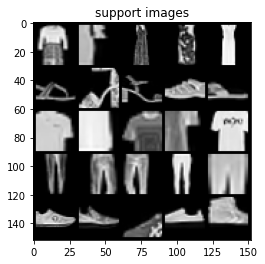

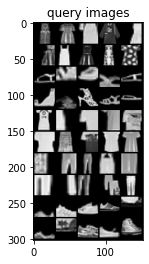

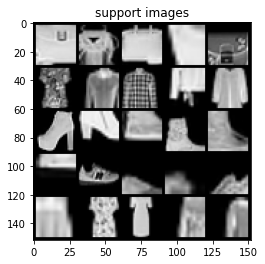

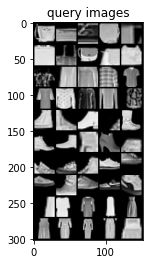

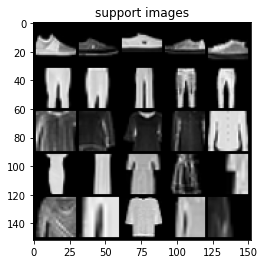

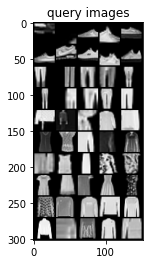

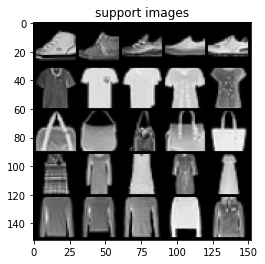

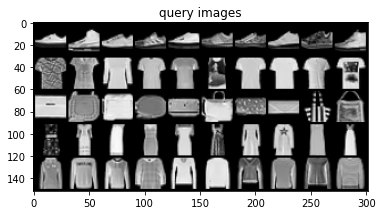

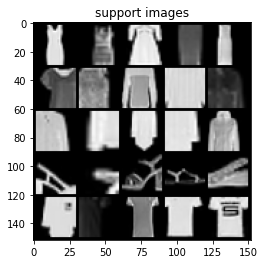

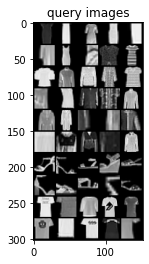

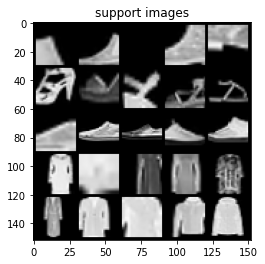

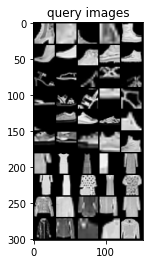

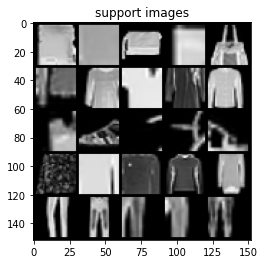

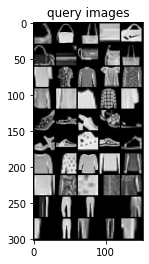

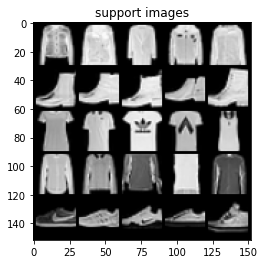

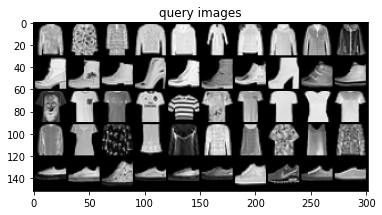

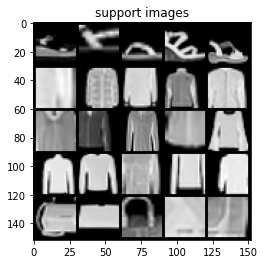

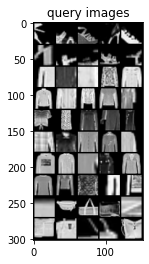

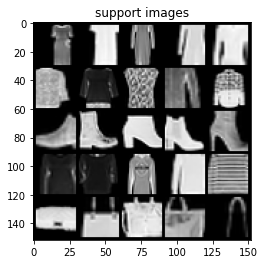

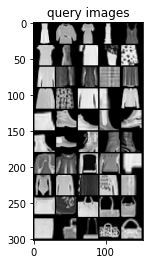

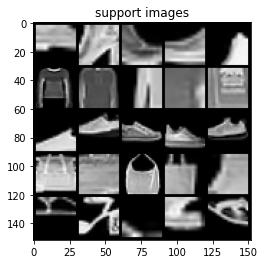

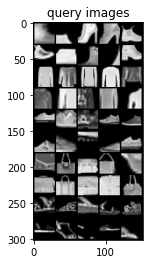

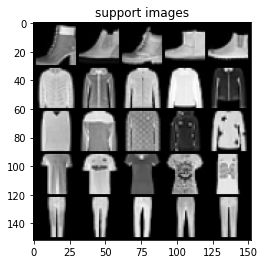

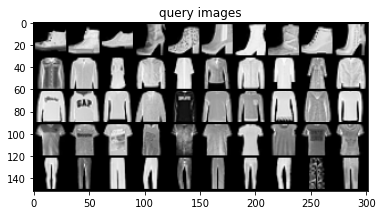

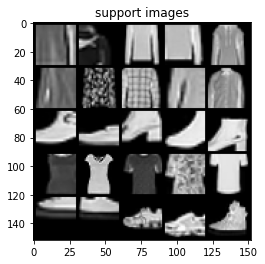

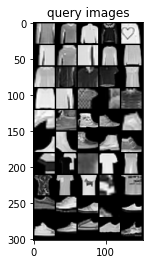

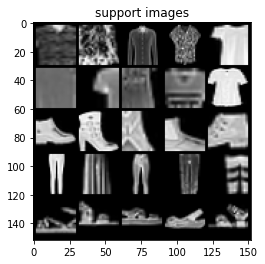

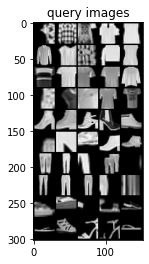

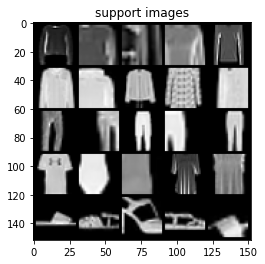

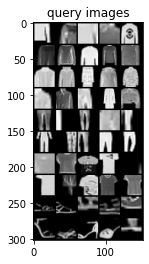

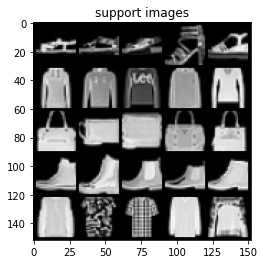

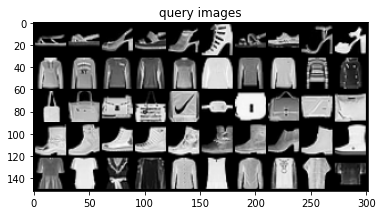

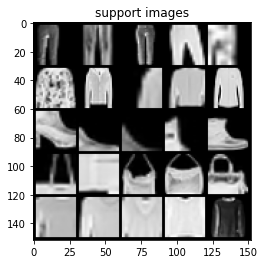

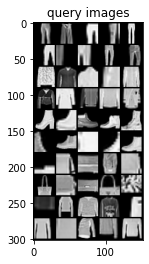

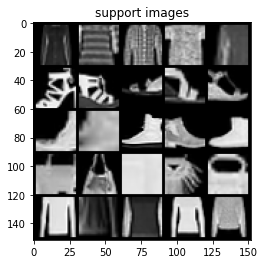

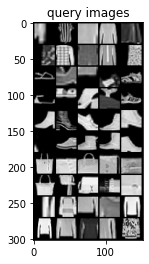

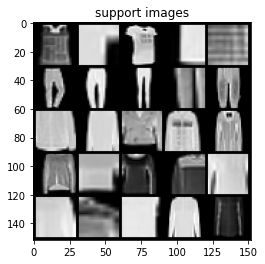

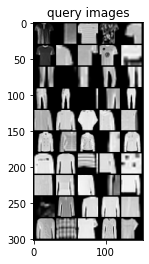

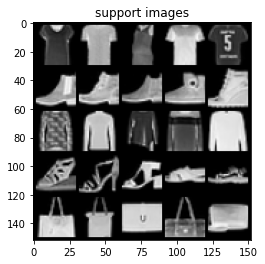

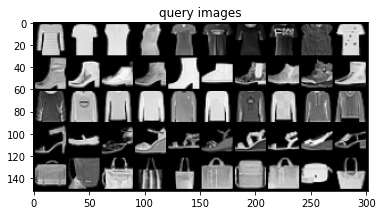

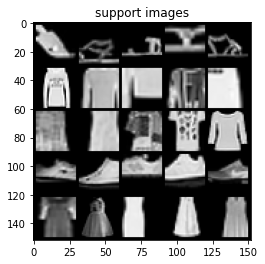

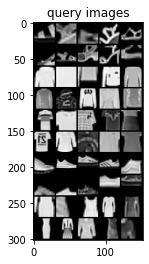

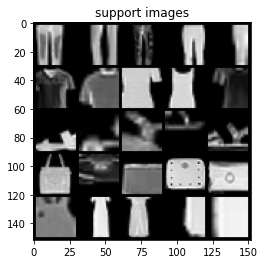

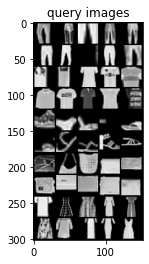

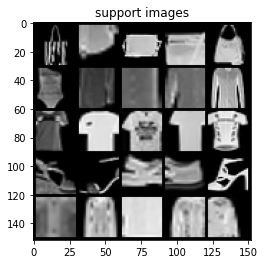

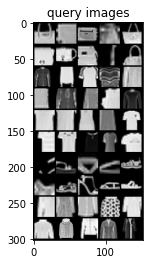

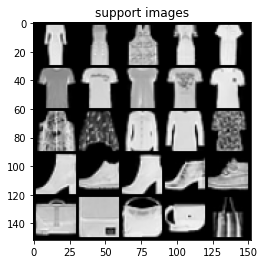

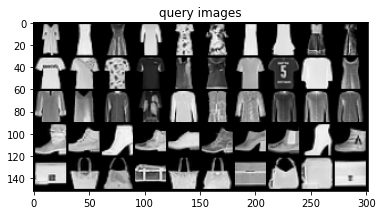

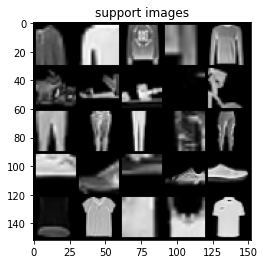

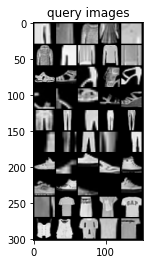

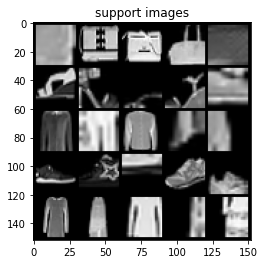

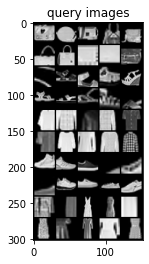

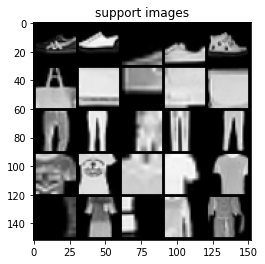

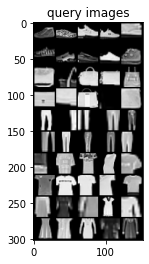

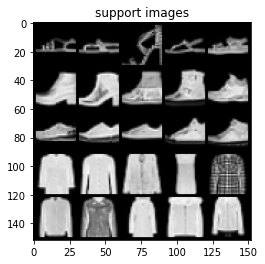

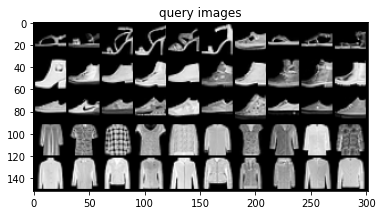

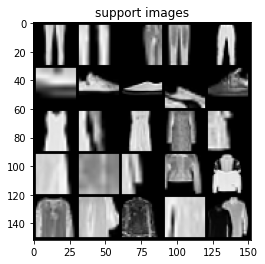

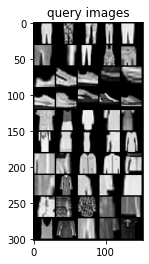

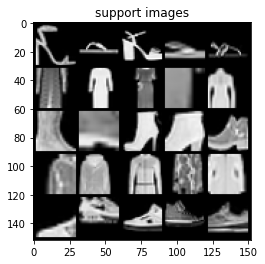

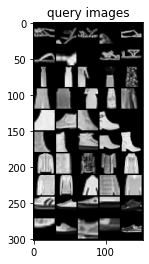

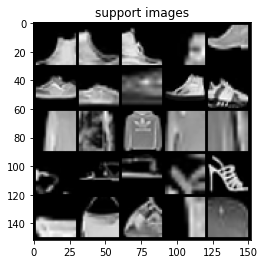

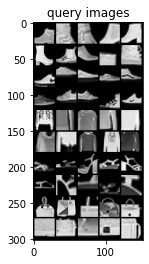

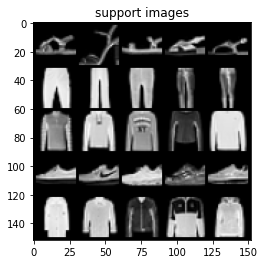

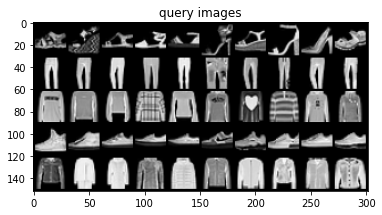

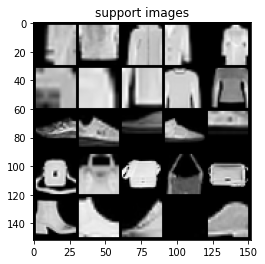

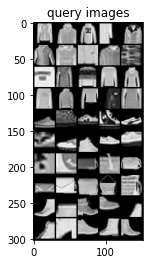

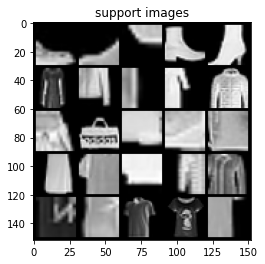

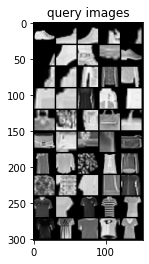

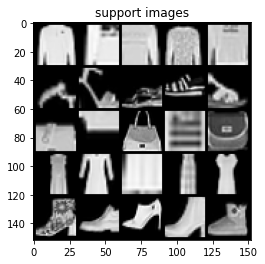

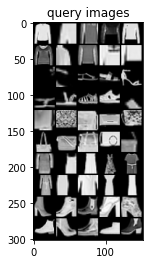

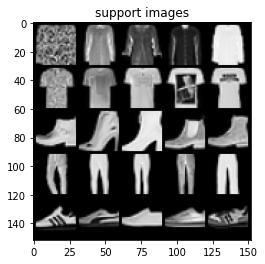

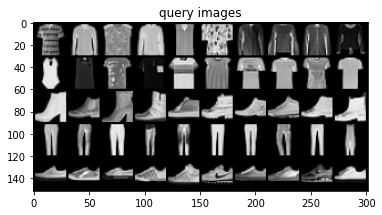

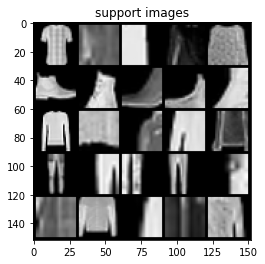

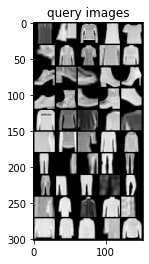

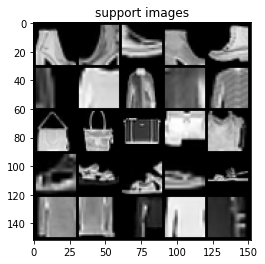

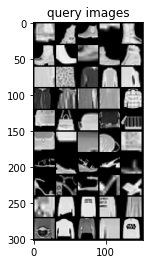

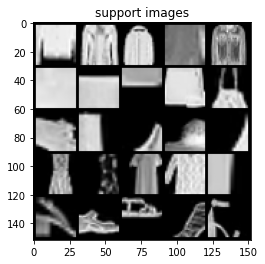

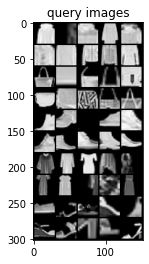

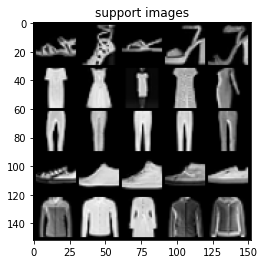

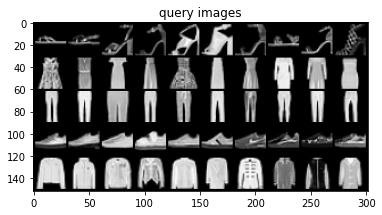

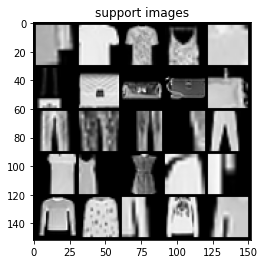

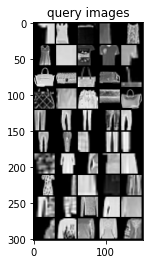

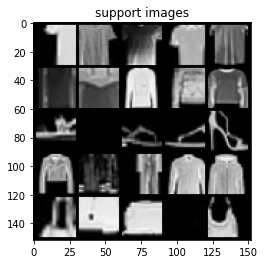

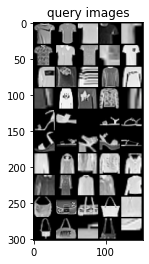

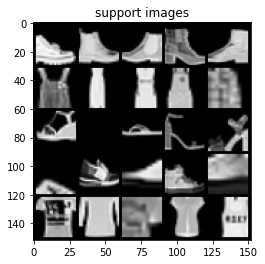

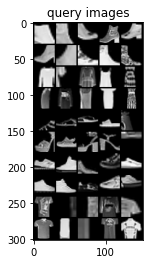

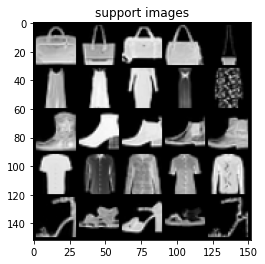

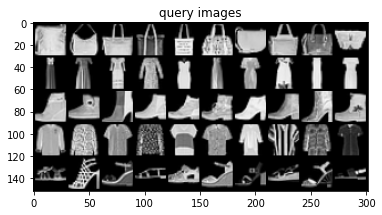

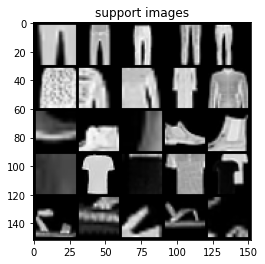

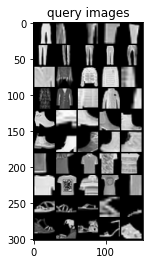

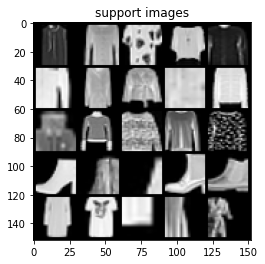

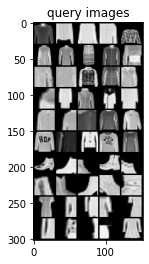

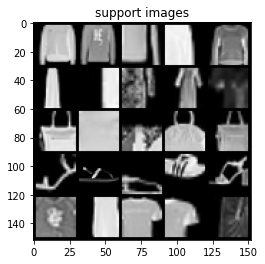

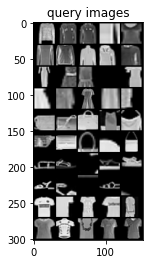

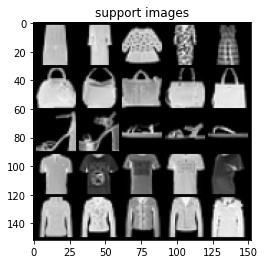

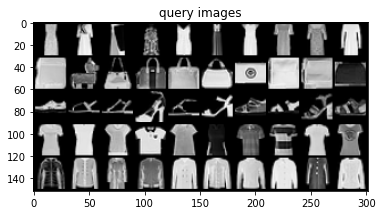

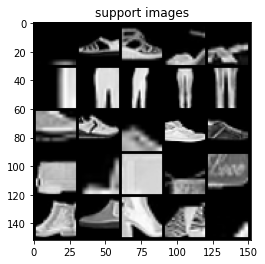

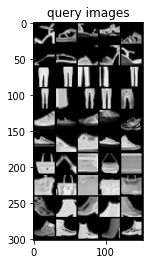

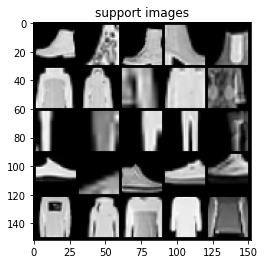

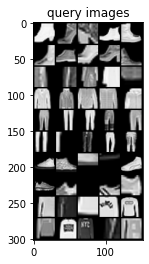

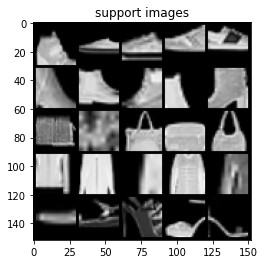

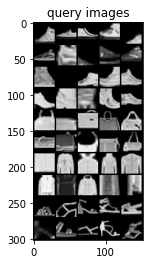

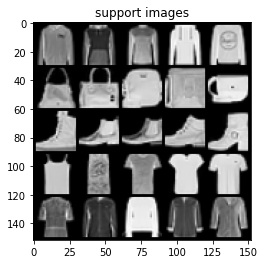

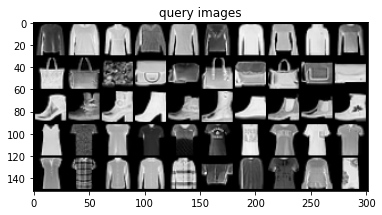

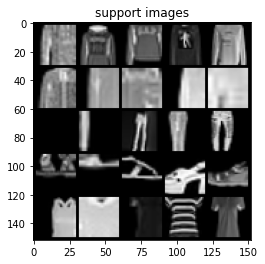

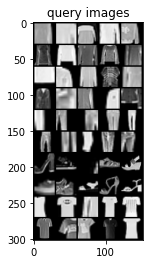

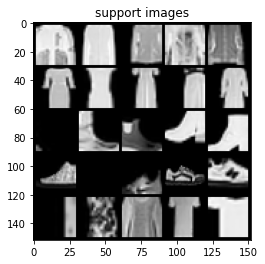

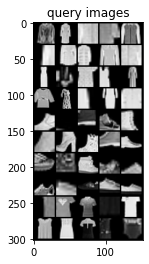

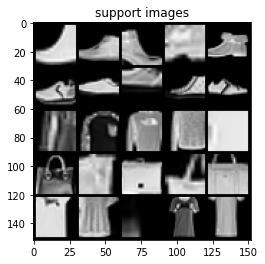

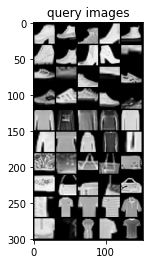

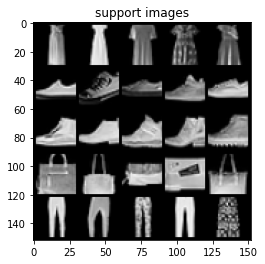

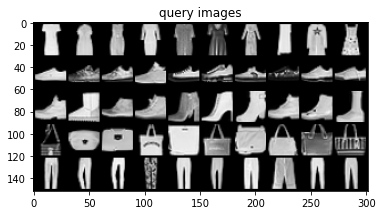

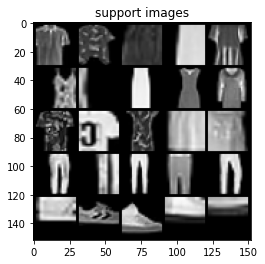

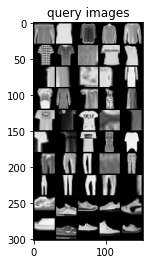

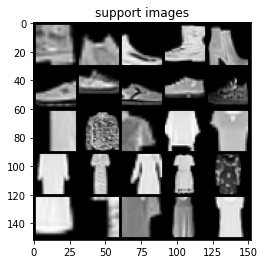

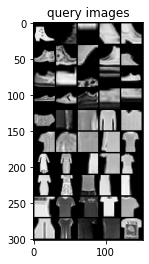

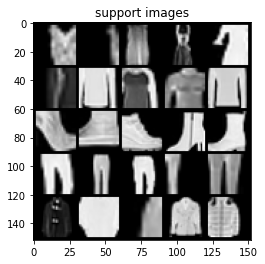

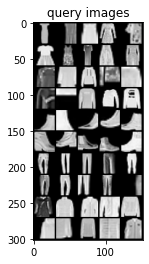

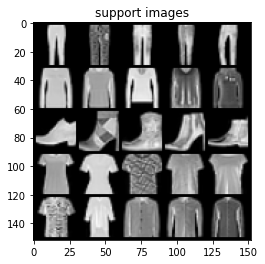

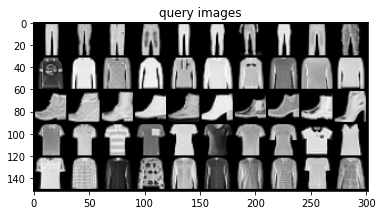

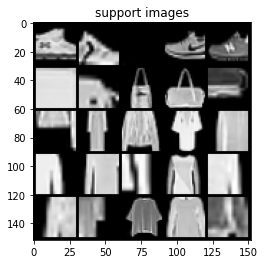

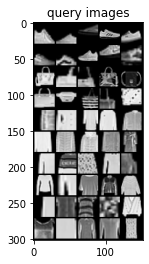

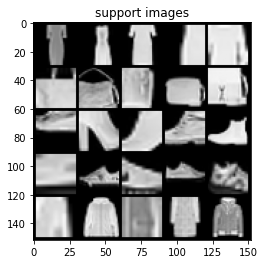

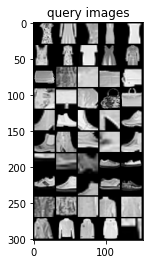

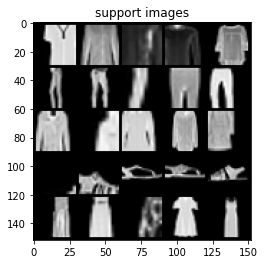

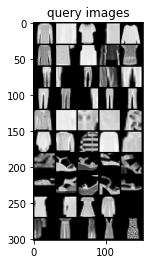

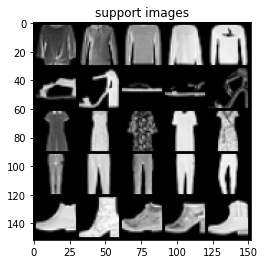

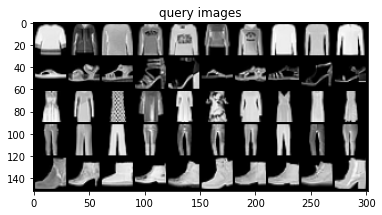

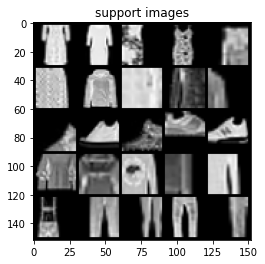

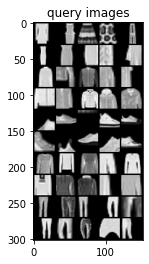

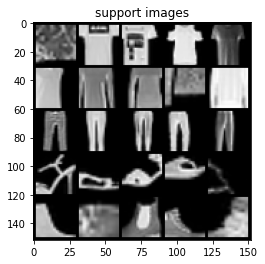

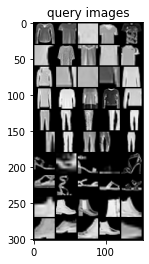

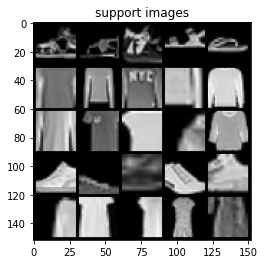

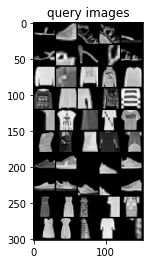

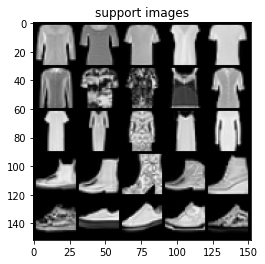

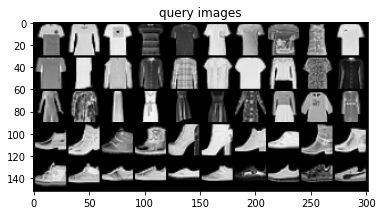

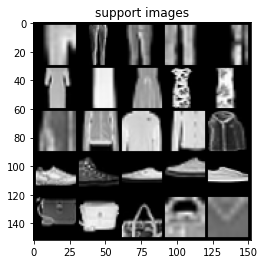

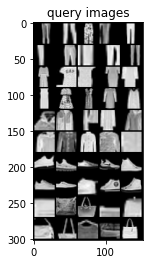

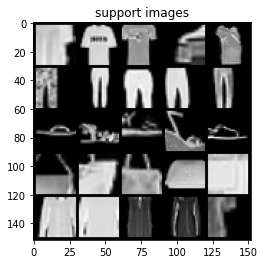

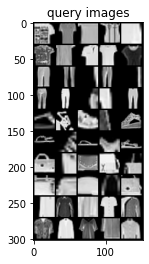

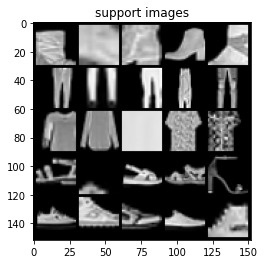

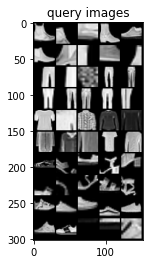

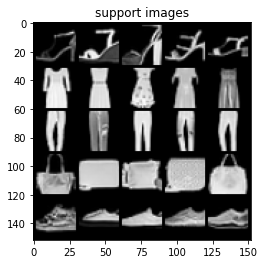

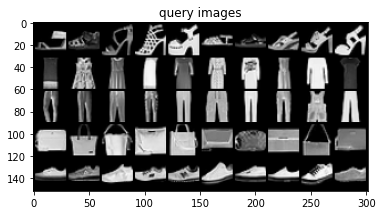

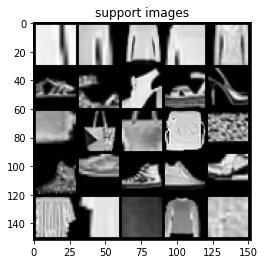

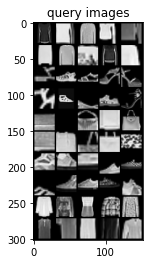

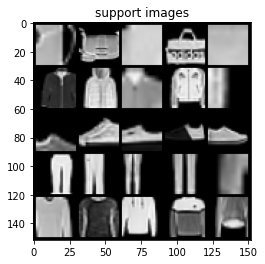

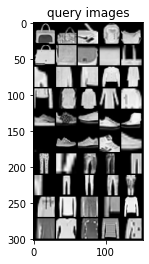

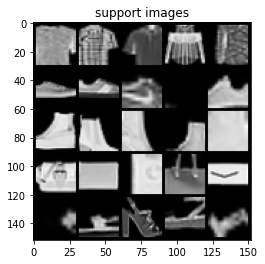

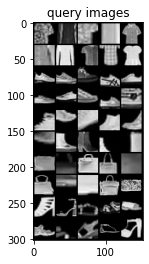

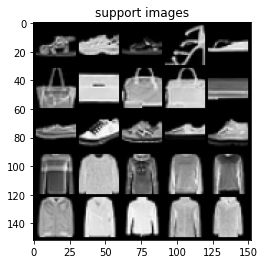

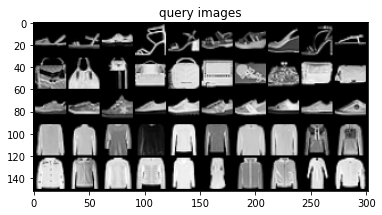

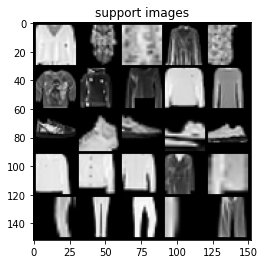

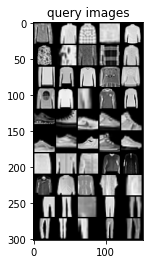

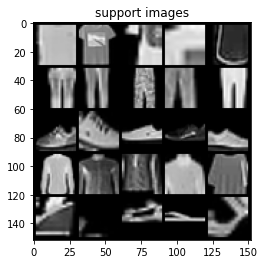

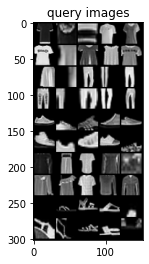

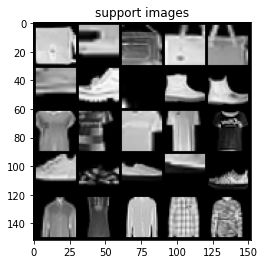

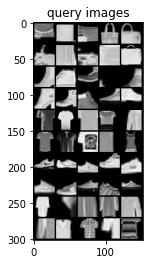

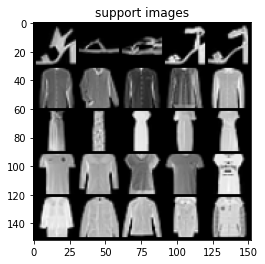

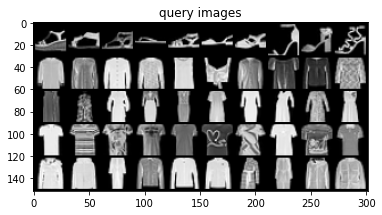

In [ ]:
print("\n The federated algorithms implemented are:\n 1) Fed-Averaging \n 2) Fed_Personalization \n 3) Fed_Proximal")
option=int(input("\nEnter the type of federated algorithm you want to run: "))
if option==1:
  tt= fed_avg()
if option==2:
  tt=fed_per()
if option==3:
  tt=fed_prox(global_model)




In [ ]:
"""
import matplotlib.pyplot as plt
rounds= range(1,num_rounds+1)
plt.plot(rounds, facc1, 'g', label='Client-1 accuracy')
plt.plot(rounds, facc2, 'b', label='Client-2 accuracy')
if num_selected==3:
 plt.plot(rounds, facc3, 'y', label='Client-3 accuracy')

plt.plot(rounds, ftacc, 'r', label='Server Testing accuracy')
plt.title('Clients Training and Server Testing Accuracies')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
if num_selected==2:
    if option==1:
      plt.savefig(r"/content/gdrive/MyDrive/FFSML images/FEMNIST/2/Fed_avg|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.png" % {"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds},dpi=200)
    if option==2:
      plt.savefig(r"/content/gdrive/MyDrive/FFSML images/FEMNIST/2/Fed_per|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.png" % {"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds},dpi=200)
    if option==3:
      plt.savefig(r"/content/gdrive/MyDrive/FFSML images/FEMNIST/2/Fed_prox|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.png" % {"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds},dpi=200)


if num_selected==3:
    if option==1:
      plt.savefig(r"/content/gdrive/MyDrive/FFSML images/FEMNIST/3/Fed_avg|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.png" % {"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds},dpi=200)
    if option==2:
      plt.savefig(r"/content/gdrive/MyDrive/FFSML images/FEMNIST/3/Fed_per|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.png" % {"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds},dpi=200)
    if option==3:
      plt.savefig(r"/content/gdrive/MyDrive/FFSML images/FEMNIST/3/Fed_prox|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.png" % {"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds},dpi=200)

plt.show()
"""

'\nimport matplotlib.pyplot as plt\nrounds= range(1,num_rounds+1)\nplt.plot(rounds, facc1, \'g\', label=\'Client-1 accuracy\')\nplt.plot(rounds, facc2, \'b\', label=\'Client-2 accuracy\')\nif num_selected==3:\n plt.plot(rounds, facc3, \'y\', label=\'Client-3 accuracy\')\n\nplt.plot(rounds, ftacc, \'r\', label=\'Server Testing accuracy\')\nplt.title(\'Clients Training and Server Testing Accuracies\')\nplt.xlabel(\'Rounds\')\nplt.ylabel(\'Accuracy\')\nplt.legend()\nif num_selected==2:\n    if option==1:\n      plt.savefig(r"/content/gdrive/MyDrive/FFSML images/FEMNIST/2/Fed_avg|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.png" % {"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds},dpi=200)\n    if option==2:\n      plt.savefig(r"/content/gdrive/MyDrive/FFSML images/FEMNIST/2/Fed_per|%(n_way)d|%(n_shot)d|%(n_query)d|%(n_rounds)d.png" % {"n_way": SN_WAY, "n_shot":SN_SHOT,"n_query": SN_QUERY,"n_rounds":num_rounds},dpi=200)\n    if option==3:\n      plt.savefig(r"/c

In [ ]:
def avg(lst):
    return sum(lst) / len(lst)
 
import math
# We relay on our previous implementation for the variance
def variance(data, ddof=0):
       n = len(data)
       mean = sum(data) / n
       return sum((x - mean) ** 2 for x in data) / (n - ddof)

def stdev(data):
    var = variance(data)
    std_dev = math.sqrt(var)
    return std_dev



In [ ]:
print("\nSever Base Train:%d"%accu)
#print('\naverage train loss %0.3g |average train acc %0.3g | test loss %0.3g | test acc: %0.3f' % (floss / num_selected, faccuracy/num_selected,ftest_loss, facc))
print("\nAverage train loss for Client 1:", avg(floss1))
print("Average train accuracy: ", avg(facc1))
print("\nStandard Deviation: ",stdev(floss1))
print("\nVaraince: ",variance(floss1))


print("\nAverage train loss for Client 2:", avg(floss2) )
print("Average train accuracy: ", avg(facc2))
print("\nStandard Deviation: ",stdev(floss2))
print("\nVaraince: ",variance(floss2))

if num_selected==3:
  print("\nAverage train loss for Client 2:", avg(floss3) )
  print("Average train accuracy: ", avg(facc3)) 
  print("\nStandard Deviation: ",stdev(floss3))
  print("\nVaraince: ",variance(floss3))


print("\nAverage train loss for Server Testing:", avg(ftloss) )
print("Average train accuracy: ", avg(ftacc))
print("\nStandard Deviation: ",stdev(ftloss))
print("\nVaraince: ",variance(ftloss))









Sever Base Train:61

Average train loss for Client 1: 0.8452805578708649
Average train accuracy:  66.1

Standard Deviation:  0.2283996035355893

Varaince:  0.05216637889521438

Average train loss for Client 2: 0.785549844801426
Average train accuracy:  70.3

Standard Deviation:  0.2834550547155762

Varaince:  0.08034676804381029

Average train loss for Client 2: 0.7481454461812973
Average train accuracy:  70.9

Standard Deviation:  0.1575166261164005

Varaince:  0.0248114875030939

Average train loss for Server Testing: 0.47986243665218353
Average train accuracy:  83.3

Standard Deviation:  0.2534285596228692

Varaince:  0.06422603483252218


In [ ]:
with open('/content/gdrive/MyDrive/FFSML images/FEMNIST/results.txt' , 'a') as f:
    
    f.write( '\nOption: %d,N-way: %d, N-shot: %d, N-query : %d, N-rounds: %d,Server Base Train: %s,Client 1: %s, Client 2: %s, Server: %s \n' %(option,SN_WAY,SN_SHOT,SN_QUERY,num_rounds,accu,facc1,facc2,ftacc)  )
    if num_selected==3:
      f.write( '\nOption: %d, N-way: %d, N-shot: %d, N-query : %d, N-rounds: %d,Server Base Train: %s,Client 1: %s, Client 2: %s,Client 3: %s, Server: %s \n' %(option,SN_WAY,SN_SHOT,SN_QUERY,num_rounds,accu,facc1,facc2,facc3,ftacc)  )
    f.write('\n mu=%f'%mu)
    f.write("\nAverage train loss for Client 1: %f"%avg(floss1))
    f.write("\nAverage train accuracy: %f" %avg(facc1))
    f.write("\nStandard Deviation: %f"%stdev(floss1))
    f.write("\nVaraince: %f"%variance(floss1))
   

    f.write("\nAverage train loss for Client 2: %f"%avg(floss2) )
    f.write("\nAverage train accuracy: %f" %avg(facc2))
    f.write("\nStandard Deviation: %f"%stdev(floss2))
    f.write("\nVaraince: %f"%variance(floss2))

    if num_selected==3:
      f.write("\nAverage train loss for Client 2: %f"%avg(floss3) )
      f.write("\nAverage train accuracy: %f" %avg(facc3)) 
      f.write("\nStandard Deviation: %f"%stdev(floss3))
      f.write("\nVaraince: %f"%variance(floss3))
    f.write("\nAverage train loss for Server Testing: %f" %avg(ftloss) )
    f.write("\nAverage train accuracy:%f"% avg(ftacc))
    f.write("\nStandard Deviation: %f"%stdev(ftloss))
    f.write("\nVaraince:%f "%variance(ftloss))

    f.write("\n TIME TAKEN : %f" %tt)

    f.write('\n****************************************************************************')

In [ ]:
$$


SyntaxError: ignored

In [ ]:
global_model

PrototypicalNetworks(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [ ]:
len(list((w_glob.keys())))

120

In [ ]:

list(w_glob)



['backbone.conv1.weight',
 'backbone.bn1.weight',
 'backbone.bn1.bias',
 'backbone.bn1.running_mean',
 'backbone.bn1.running_var',
 'backbone.bn1.num_batches_tracked',
 'backbone.layer1.0.conv1.weight',
 'backbone.layer1.0.bn1.weight',
 'backbone.layer1.0.bn1.bias',
 'backbone.layer1.0.bn1.running_mean',
 'backbone.layer1.0.bn1.running_var',
 'backbone.layer1.0.bn1.num_batches_tracked',
 'backbone.layer1.0.conv2.weight',
 'backbone.layer1.0.bn2.weight',
 'backbone.layer1.0.bn2.bias',
 'backbone.layer1.0.bn2.running_mean',
 'backbone.layer1.0.bn2.running_var',
 'backbone.layer1.0.bn2.num_batches_tracked',
 'backbone.layer1.1.conv1.weight',
 'backbone.layer1.1.bn1.weight',
 'backbone.layer1.1.bn1.bias',
 'backbone.layer1.1.bn1.running_mean',
 'backbone.layer1.1.bn1.running_var',
 'backbone.layer1.1.bn1.num_batches_tracked',
 'backbone.layer1.1.conv2.weight',
 'backbone.layer1.1.bn2.weight',
 'backbone.layer1.1.bn2.bias',
 'backbone.layer1.1.bn2.running_mean',
 'backbone.layer1.1.bn2.runn

In [ ]:
base_layers=78
len(list(w_glob.keys())[base_layers:])


42

In [ ]:
list(w_glob.keys())[base_layers:]

['backbone.layer3.1.conv1.weight',
 'backbone.layer3.1.bn1.weight',
 'backbone.layer3.1.bn1.bias',
 'backbone.layer3.1.bn1.running_mean',
 'backbone.layer3.1.bn1.running_var',
 'backbone.layer3.1.bn1.num_batches_tracked',
 'backbone.layer3.1.conv2.weight',
 'backbone.layer3.1.bn2.weight',
 'backbone.layer3.1.bn2.bias',
 'backbone.layer3.1.bn2.running_mean',
 'backbone.layer3.1.bn2.running_var',
 'backbone.layer3.1.bn2.num_batches_tracked',
 'backbone.layer4.0.conv1.weight',
 'backbone.layer4.0.bn1.weight',
 'backbone.layer4.0.bn1.bias',
 'backbone.layer4.0.bn1.running_mean',
 'backbone.layer4.0.bn1.running_var',
 'backbone.layer4.0.bn1.num_batches_tracked',
 'backbone.layer4.0.conv2.weight',
 'backbone.layer4.0.bn2.weight',
 'backbone.layer4.0.bn2.bias',
 'backbone.layer4.0.bn2.running_mean',
 'backbone.layer4.0.bn2.running_var',
 'backbone.layer4.0.bn2.num_batches_tracked',
 'backbone.layer4.0.downsample.0.weight',
 'backbone.layer4.0.downsample.1.weight',
 'backbone.layer4.0.downsamp

In [ ]:
list(w_glob.keys())[:base_layers]

['backbone.conv1.weight',
 'backbone.bn1.weight',
 'backbone.bn1.bias',
 'backbone.bn1.running_mean',
 'backbone.bn1.running_var',
 'backbone.bn1.num_batches_tracked',
 'backbone.layer1.0.conv1.weight',
 'backbone.layer1.0.bn1.weight',
 'backbone.layer1.0.bn1.bias',
 'backbone.layer1.0.bn1.running_mean',
 'backbone.layer1.0.bn1.running_var',
 'backbone.layer1.0.bn1.num_batches_tracked',
 'backbone.layer1.0.conv2.weight',
 'backbone.layer1.0.bn2.weight',
 'backbone.layer1.0.bn2.bias',
 'backbone.layer1.0.bn2.running_mean',
 'backbone.layer1.0.bn2.running_var',
 'backbone.layer1.0.bn2.num_batches_tracked',
 'backbone.layer1.1.conv1.weight',
 'backbone.layer1.1.bn1.weight',
 'backbone.layer1.1.bn1.bias',
 'backbone.layer1.1.bn1.running_mean',
 'backbone.layer1.1.bn1.running_var',
 'backbone.layer1.1.bn1.num_batches_tracked',
 'backbone.layer1.1.conv2.weight',
 'backbone.layer1.1.bn2.weight',
 'backbone.layer1.1.bn2.bias',
 'backbone.layer1.1.bn2.running_mean',
 'backbone.layer1.1.bn2.runn

In [ ]:
list(w_glob.keys())[base_layers:]

['backbone.layer3.1.conv1.weight',
 'backbone.layer3.1.bn1.weight',
 'backbone.layer3.1.bn1.bias',
 'backbone.layer3.1.bn1.running_mean',
 'backbone.layer3.1.bn1.running_var',
 'backbone.layer3.1.bn1.num_batches_tracked',
 'backbone.layer3.1.conv2.weight',
 'backbone.layer3.1.bn2.weight',
 'backbone.layer3.1.bn2.bias',
 'backbone.layer3.1.bn2.running_mean',
 'backbone.layer3.1.bn2.running_var',
 'backbone.layer3.1.bn2.num_batches_tracked',
 'backbone.layer4.0.conv1.weight',
 'backbone.layer4.0.bn1.weight',
 'backbone.layer4.0.bn1.bias',
 'backbone.layer4.0.bn1.running_mean',
 'backbone.layer4.0.bn1.running_var',
 'backbone.layer4.0.bn1.num_batches_tracked',
 'backbone.layer4.0.conv2.weight',
 'backbone.layer4.0.bn2.weight',
 'backbone.layer4.0.bn2.bias',
 'backbone.layer4.0.bn2.running_mean',
 'backbone.layer4.0.bn2.running_var',
 'backbone.layer4.0.bn2.num_batches_tracked',
 'backbone.layer4.0.downsample.0.weight',
 'backbone.layer4.0.downsample.1.weight',
 'backbone.layer4.0.downsamp

In [ ]:
     
         #clients training after Fedper
         if i==0:
           s1_images,s1_labels,q1_images,q1_labels,class_ids1=client1_data()
           w1,fl1,fa1 = client_update(client_models[0], opt[0], s1_images,s1_labels,q1_images,q1_labels,class_ids1)
         
         if i==1:
           s2_images,s2_labels,q2_images,q2_labels,class_ids2=client2_data()
           w2,fl2,fa2 = client_update1(client_models[1], opt[1], s2_images,s2_labels,q2_images,q2_labels,class_ids2)
           floss2.append(fl2)
           facc2.append(fa2)

        

In [ ]:
def avg(lst):
    return sum(lst) / len(lst)
 
print("\nFinal Average Loss of client training ",avg(final_losses_train))
print("\nFinal Average Accuracy of client training ",avg(final_acc_train))
print("\nFinal Average Loss of server testing ",avg(final_losses_test))
print("\nFinal Average Accuracy of server testing ",avg(final_acc_test))



In [ ]:
print("\nTraining on Client-1 data....") 
client_update(client_models[0],opt[0], s1_images,s1_labels,q1_images, q1_labels) #testing C1 on new data



#for client 2
print("\nTraining on Client-2 data....")
client_update(client_models[1],opt[1],s2_images,s2_labels,q2_images, q2_labels)   #client-2 new data

print("\nAggregating the client models with Global model...")
M1=server_aggregate(global_model, client_models)    #server aggregation
    


print("Testing aggregated models on new test data ...")
test(M1,s_images,s_labels,q_images, q_labels) #aggregated model on new test data on server side


